<div class="alert alert-block alert-info">
<b>Note:</b><br>

-  Previously, I had built the model using all the features, and the model overfits the training and test data (Precision is 100% for training and test). However, after performing feature selection, we were able to reduce the model overfit and the generalized model well. Also, Accuracy, Recall, Precision and F1 score looks promising.<br>

-  Due to time constraint and work conflict, I have used only GridSearch to select the best Hyper Parameters.<br>
-  If we expand the range of values in parameters, we can see marginal improvment in the model scores, however for this excercise I have kept the parameter range to minimal.<br>
    
</div>


# Context
- The real estate sector can be very unpredictable and susceptible to a downturn in times of economic crisis. Whenever the economy suffers, the number of stressed assets can become a huge problem for housing finance companies. The bad debt and stressed assets result in a liquidity crunch and impact the banks that are lenders to both developers and property buyers. Timely risk analysis of these accounts can help lenders forecast the number and value of accounts that are at risk of developing into a Bad Debt in near future and eventually help them mitigate the losses.

**About the Data**
The data belongs to the billing systems of various societies. These societies could be residential or public. The data has been collected over the years and has been summarised according to their total amount billed versus the total amount generated from the consumers. For each account, there is a label indicating whether an account resulted in a Bad Debt (the account that would be unable to pay the amount).

# Objective
- The objective is to build a classification model which can predict whether an account is becoming a Bad Debt. This prediction can help to forecast the number (and value) of accounts that are at risk of developing into a Bad Debt.

# Data Dictionary

    1. AccID: An unique id for the account
    2. CategoryID: An unique id for the category of the society
    3. Category: Category of society 
    4. Value: The market value of the particular property (account)
    5. PropertySize: The size of the property in square metres
    6. BillingAmt: The total amount payable by the resident to the society management
    7. AverageBillingAmt: The average amount payable by the resident to the society management
    8. CollectedAmt: The total amount collected from the resident 
    9. AverageCollectedAmt: The average amount collected from the resident 
    10. DebtAmt: The Total Debt that is at 90 days or more
    11. WriteOffAmt: The Total amount of debt that has been written off
    12. CollectionRatio: The ratio between the Total amount collected and Total Billing (ie. CollectedAmt/ BillingAmt)
    13. DebtBillingRatio: The ratio between the Total Debt and Total Billing (ie. (Total Debt + Total Write Off)/Total Billing)
    14. TotalElectricityBill: The total amount billed for electricity. This field was put in place because it is used as a means to recover debt - ie. If an amount is outstanding for any service the management has the right to cut a consumer's electricity connection.
    15. HasID: The resident has an ID number. 
    16. Label: 1 = Is considered to be a Bad Debt, 0 = Not considered to be a Bad Debt

In [1]:
# import all the relevant libraries

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# data scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LassoCV, ElasticNet, SGDClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree, svm
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ( AdaBoostClassifier,GradientBoostingClassifier, RandomForestClassifier)
from catboost import CatBoostClassifier
import lightgbm as lgbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

# to display max column width
pd.set_option('display.max_columns', None)

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}

In [3]:
#import the file
extract=pd.read_csv('Predicting Bad Debt Societies-data dictionary-train data.csv')

In [4]:
# make a copy of the file
df=extract.copy()

In [5]:
#view the data
df.head()

,AccID,CategoryID,Category,Value,PropertySize,BillingAmt,AverageBillingAmt,CollectedAmt,AverageCollectedAmt,DebtAmt,WriteOffAmt,CollectionRatio,DebtBillingRatio,TotalElectricityBill,HasID,Label
0,c8f5a7fa-4b2b-470f-8ad5-1c367a3c934a,1,Residential,2674700,585,43717,729,43416,4342,0,0,0.99,0.00,0,0,0
1,95daa45d-3dfd-4c60-aae4-05e78b0de26e,1,Residential,36000,315,378,3,522,522,0,0,1.38,0.00,0,0,0
2,40536c2d-c0a2-4486-b0aa-60b36dfa290a,1,Residential,700000,528,25150,345,25104,349,0,0,1.00,0.00,10715,1,0
3,52a2254d-44e5-4dc9-8e08-1b135096172c,5,Municipal,40000,0,4773,133,0,0,7319,0,0.00,1.53,0,1,1
4,1e0363e4-2029-4b62-a9ec-d909cee000cb,1,Residential,125800,0,-4,0,445,445,0,0,-121.26,0.00,0,0,0


In [83]:
# check the number of columns and rows
print("Data set contains {a} rows and {b} columns.".format(a=df.shape[0],b=df.shape[1]))

Data set contains 100476 rows and 16 columns.


In [8]:
# lets drop the ID of the customers, it is just a label attached to customers
df1=df.drop(['AccID'],axis=1)
df1.head() # lets view the column after droping the ID column

,CategoryID,Category,Value,PropertySize,BillingAmt,AverageBillingAmt,CollectedAmt,AverageCollectedAmt,DebtAmt,WriteOffAmt,CollectionRatio,DebtBillingRatio,TotalElectricityBill,HasID,Label
0,1,Residential,2674700,585,43717,729,43416,4342,0,0,0.99,0.00,0,0,0
1,1,Residential,36000,315,378,3,522,522,0,0,1.38,0.00,0,0,0
2,1,Residential,700000,528,25150,345,25104,349,0,0,1.00,0.00,10715,1,0
3,5,Municipal,40000,0,4773,133,0,0,7319,0,0.00,1.53,0,1,1
4,1,Residential,125800,0,-4,0,445,445,0,0,-121.26,0.00,0,0,0


In [8]:
# check for missing values in the data.
df1.isnull().sum()

CategoryID              0
Category                0
Value                   0
PropertySize            0
BillingAmt              0
AverageBillingAmt       0
CollectedAmt            0
AverageCollectedAmt     0
DebtAmt                 0
WriteOffAmt             0
CollectionRatio         0
DebtBillingRatio        0
TotalElectricityBill    0
HasID                   0
Label                   0
dtype: int64

- No missing values in the data

In [9]:
# get basic statistics of numerical columns.
pd.options.display.float_format = '{:,.2f}'.format # to remove scientific notation
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
CategoryID,"70,333.00",2.24,2.73,1.00,1.00,1.00,2.00,13.00
Value,"70,333.00","708,363.62","2,942,857.86",0.00,"35,000.00","92,000.00","748,400.00","300,000,000.00"
PropertySize,"70,333.00","740,968.00","5,531,770.01",0.00,276.00,510.00,"1,165.00","270,515,963.00"
BillingAmt,"70,333.00","10,732.63","100,603.91","-914,820.00",455.00,"3,105.00","8,642.00","15,108,481.00"
AverageBillingAmt,"70,333.00",582.43,"6,539.97","-79,384.00",22.00,106.00,280.00,"805,044.00"
CollectedAmt,"70,333.00","9,543.24","98,420.80","-219,260.00",0.00,350.00,"7,315.00","15,108,481.00"
AverageCollectedAmt,"70,333.00","2,002.27","34,317.26","-219,260.00",0.00,100.00,763.00,"6,828,297.00"
DebtAmt,"70,333.00","9,688.26","49,891.19",0.00,0.00,0.00,"2,302.00","6,322,610.00"
WriteOffAmt,"70,333.00",629.04,"16,963.82",0.00,0.00,0.00,0.00,"4,306,605.00"
CollectionRatio,"70,333.00",24.17,"6,472.89","-115,000.00",0.00,0.49,1.00,"1,701,912.00"


- Value: we can observe that the highest value of the house price is 30 million and some house price is 0, This has to check with the business why we have property value with 0, is it genuine or typo, need confirmation on this.
- PropertySize: some property size is 0, and max property size is very high. We need confirmation from the business why property size is 0 for few property, is it genuine or typo.
- Bill Amount: We can observe that the total bill amount has a negative value, which indicates that some residents have not paid society charges. The average payable due amount is 10,736, which is significantly high.
- Average bill amount: on average, the resident must pay 582.43 for the society. However, some residents have not paid the society charges, and the Average due is around 79k.
- Collected Amount: On average society collected 98k, yet to collect 220k, and the max collected amount is 15million.
- Debt Amount:  On average, the total debt over 90 days or more is 9.5k min being 0, and the max debt amount is 6mil.
- Write off amount: Average write amount is 629, max write off amount is 4mil; this is significantly high.  Average Write off amount is more than the average collected amount from the residents. 
- Collection Ratio and Debt billing Ratio: We can observe that the average ratio for these 2 is very minimal, just 24 and 19 dollars. This indicates that Residents in some of the societies have a terrible reputation for paying the society charges , and the society ends up writing off the debt. 
- Total Electricity Bill: Average electricity bill amount is 4k; this is significantly higher; some residents have not paid the electricity bill, so the due amount to recover is 220k; again, this is a considerably more elevated amount to recover.

In [10]:
# get basic statistics of categorical columns.
df1.describe(include=['object']).T

,count,unique,top,freq
Category,70333,12,Residential,52053


In [11]:
#lets check the frequency of each observations from the category columns.
# also we can check for any discrepency or miss spelt observations in this.
cat_col=df1.select_dtypes(include='object')

for column in cat_col:
    
    print(df1[column].value_counts())
    print('-'*30)

Residential                 52053
Agricultural                 5339
Unknown                      4618
Business                     4047
Government                   2039
Municipal                    1543
Educational                   277
Place of Worship              234
Industry                      125
Infrastructure                 47
Public Benefit                  9
Environmental Management        2
Name: Category, dtype: int64
------------------------------


- We can observe that most of the property are residential, followed by Agricultural, there is a larger number of property which are unknown. Few Public related properties are minimal.

In [9]:
# lets tranform object data type to category data type, this will save the memory.

for feature in df1.columns:
    if df1[feature].dtype=='object':
        df1[feature]=pd.Categorical(df1[feature])

In [13]:
# get basic info of the data
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70333 entries, 0 to 70332
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   CategoryID            70333 non-null  int64   
 1   Category              70333 non-null  category
 2   Value                 70333 non-null  int64   
 3   PropertySize          70333 non-null  int64   
 4   BillingAmt            70333 non-null  int64   
 5   AverageBillingAmt     70333 non-null  int64   
 6   CollectedAmt          70333 non-null  int64   
 7   AverageCollectedAmt   70333 non-null  int64   
 8   DebtAmt               70333 non-null  int64   
 9   WriteOffAmt           70333 non-null  int64   
 10  CollectionRatio       70333 non-null  float64 
 11  DebtBillingRatio      70333 non-null  float64 
 12  TotalElectricityBill  70333 non-null  int64   
 13  HasID                 70333 non-null  int64   
 14  Label                 70333 non-null  int64   
dtypes:

-------

# EDA (Exoloratory Data analysis).
- Exploratory data analysis (EDA) is used to analyze and investigate data sets and summarize their main characteristics, often employing data visualization methods. It helps determine how best to manipulate data sources to get the answers we need, making it easier for us to discover patterns, spot anomalies, test a hypothesis, or check assumptions.

## Univariate data analysis
- Understanding how single variable observation is spread across to find patterns.

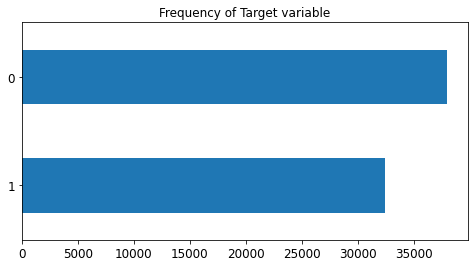

In [14]:
# analyzing targer variable
plt.figure(figsize=(8,4))
x=df1['Label'].value_counts().sort_values().tail(12).plot(kind='barh', fontsize=12)
plt.title("Frequency of Target variable");

In [15]:
df1['Label'].value_counts(normalize=True)

0   0.54
1   0.46
Name: Label, dtype: float64

- From the above we can observe that we have significantly higher bad debts. Around 46% of the customers are bad debts customers.

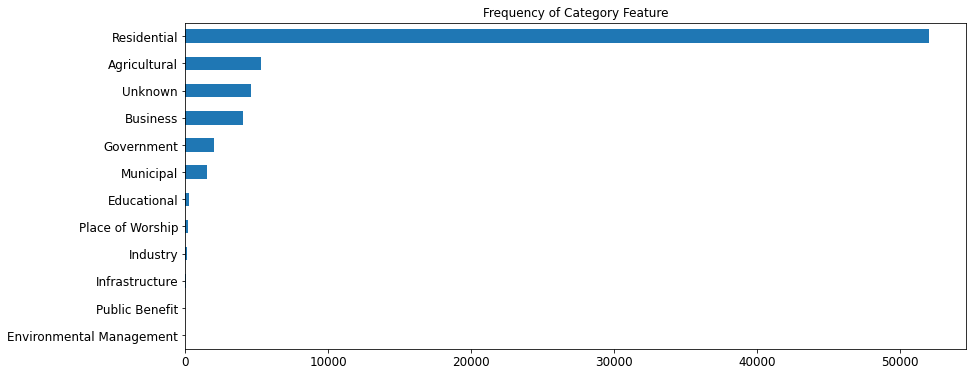

In [17]:
plt.figure(figsize=(14,6))
x=df1['Category'].value_counts().sort_values().tail(12).plot(kind='barh', fontsize=12)
plt.title("Frequency of Category Feature");

In [51]:
df1['Category'].value_counts(normalize=True)

Residential                0.74
Agricultural               0.08
Unknown                    0.07
Business                   0.06
Government                 0.03
Municipal                  0.02
Educational                0.00
Place of Worship           0.00
Industry                   0.00
Infrastructure             0.00
Public Benefit             0.00
Environmental Management   0.00
Name: Category, dtype: float64

- 74% of the property are residential, rest other posses less than 10%.

**To check if Category and CategoryID variables are the same.**

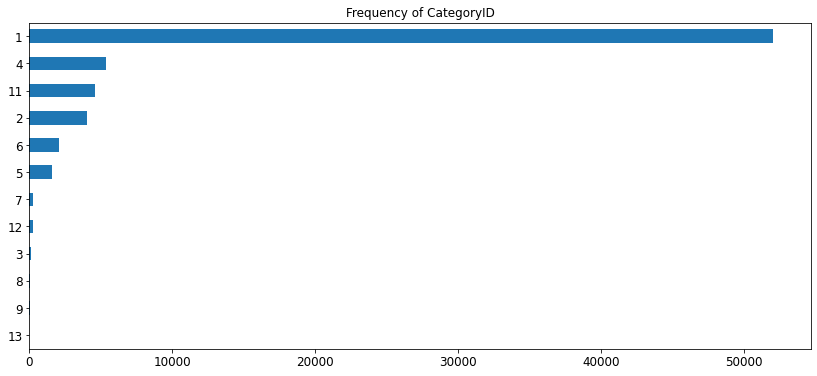

In [18]:
plt.figure(figsize=(14,6))
x=df1['CategoryID'].value_counts().sort_values().tail(12).plot(kind='barh', fontsize=12)
plt.title("Frequency of CategoryID");

In [19]:
df1.groupby(['Category'])['CategoryID'].value_counts().sort_values(ascending=False)

Category                  CategoryID
Residential               1             52053
Agricultural              4              5339
Unknown                   11             4618
Business                  2              4047
Government                6              2039
Municipal                 5              1543
Educational               7               277
Place of Worship          12              234
Industry                  3               125
Infrastructure            8                47
Public Benefit            9                 9
Environmental Management  13                2
Name: CategoryID, dtype: int64

- From the above we can observe that both Category and CategoryID are the same, we can keep any one of the variable and drop the other.

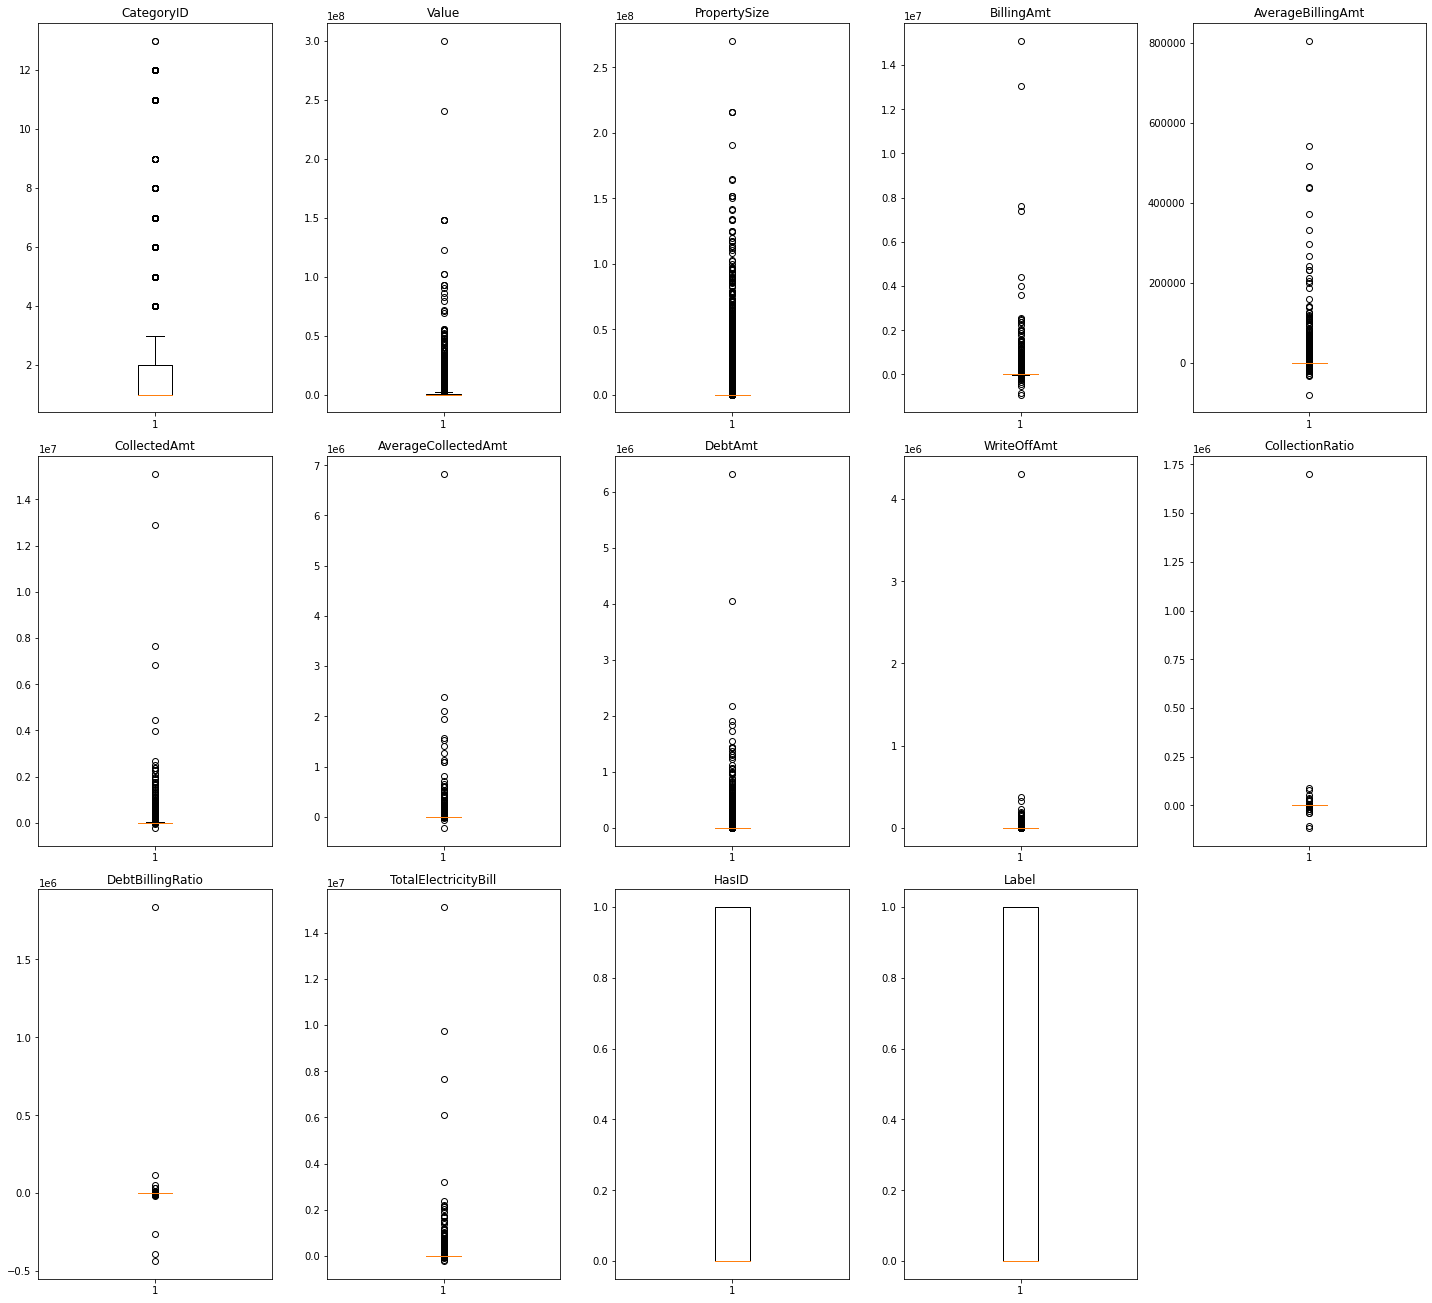

In [33]:
# Lets apply box plot to check the distribution of data.

numeric_columns = df1.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(20,30))

for i, variable in enumerate(numeric_columns):
                     plt.subplot(5,5,i+1)
                     plt.boxplot(data[variable],whis=1.5)
                     plt.tight_layout()
                     plt.title(variable)

plt.show()

- From the above we can observe that most of the features are right skewed or positive skew with significant higher outliers containing zeros and negative values.

--------

## Bivariate data analysis
- Understanding how two variables and multiple variables datas are spread across to find patterns.Understanding how single variable observation is spread across to find patterns.

In [19]:
# Lets create a function for stacked bar charts to compare the Target variable agains the other independent variable.
colors = ["#0B5394", "#6FA8DC"] # color of the bars

def stacked_bar(feature):
    
    tab=pd.crosstab(feature,df1["Label"],margins=True)
    print(tab)
    print('-'*120)
    
    tab1=pd.crosstab(feature,df1["Label"],normalize='index')
    tab1.plot(kind='bar',stacked=True,figsize=(10,5),edgecolor='white',color=colors)
    plt.legend(loc='upper left',bbox_to_anchor=(1,1),edgecolor='white')
    plt.xticks(rotation=90);

Label                         0      1    All
Category                                     
Agricultural               3919   1420   5339
Business                   2534   1513   4047
Educational                 245     32    277
Environmental Management      1      1      2
Government                 1132    907   2039
Industry                    105     20    125
Infrastructure               23     24     47
Municipal                   591    952   1543
Place of Worship            112    122    234
Public Benefit                6      3      9
Residential               28071  23982  52053
Unknown                    1200   3418   4618
All                       37939  32394  70333
------------------------------------------------------------------------------------------------------------------------


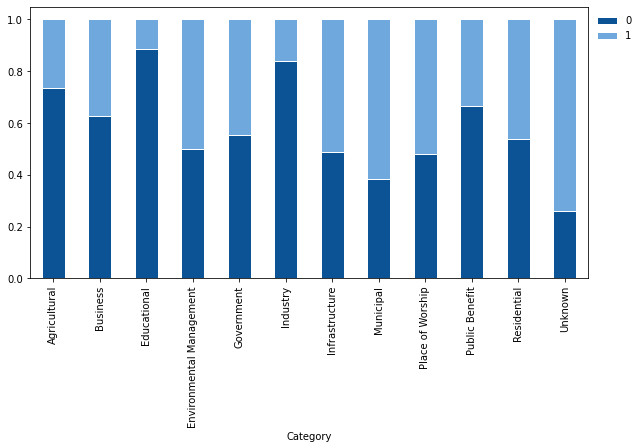

In [21]:
# lets visualize how the target variable (CourseAttemptStatus) corresponds to GenderIdentityCode.
stacked_bar(df1["Category"])

- From the above we can observe that Unknown having higher bad debts, followed by all the government agencies (except Public Benefit) having higher bad debts. Least being Industry, Educational and Public Benifits.

Label      0      1    All
HasID                     
0      27125  13271  40396
1      10814  19123  29937
All    37939  32394  70333
------------------------------------------------------------------------------------------------------------------------


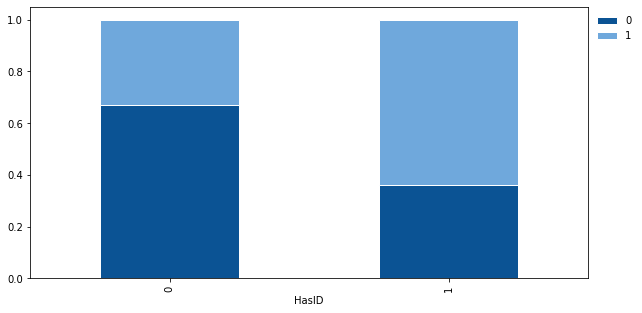

In [22]:
# lets visualize how the target variable (CourseAttemptStatus) corresponds to GenderIdentityCode.
stacked_bar(df1["HasID"])

- Higher bad debts is for the customers who have ID.

In [12]:
# function to create box plot. Target variable vs numerical

def box_plt(feature, variable):
    plt.figure(figsize=(10,5)) 
    
    sns.boxplot(feature, x='Label',y=variable, data=df1,palette='coolwarm',showmeans=True,
           meanprops={"marker":"^",
                    "markerfacecolor":"white",
                    "markeredgecolor":"black",
                    "markersize":"8"});

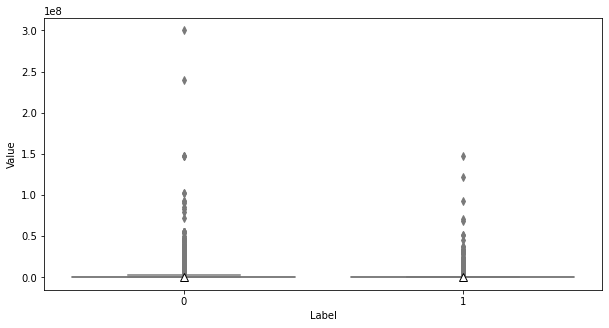

In [24]:
# lets visualize how the target variable (CourseAttemptStatus) corresponds to EFTSL.
box_plt(df1["Label"], df1['Value'])

In [35]:
# to support above box plot analysis.
pd.options.display.float_format = '{:,.2f}'.format # to remove scientific notation
df1.groupby(['Label'])['Value'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,"37,939.00","970,505.32","3,589,634.11",0.00,"37,000.00","321,600.00","1,020,000.00","300,000,000.00"
1,"32,394.00","401,350.15","1,880,859.88",0.00,"31,590.00","60,000.00","194,525.00","148,000,000.00"


- From the above we can obseve that for the Bad debts customers average value of the property is around 400k. (lesser property value for bad debts customers) max value of the property for bad debts customers is 14 mil. 

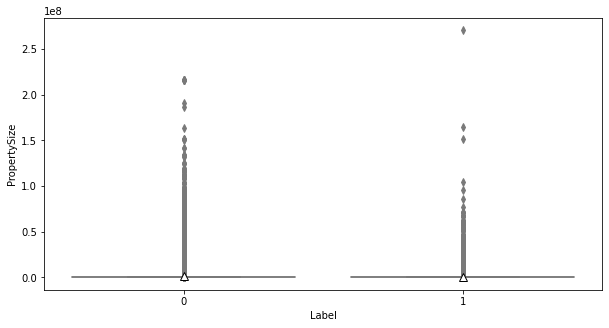

In [14]:
# lets visualize how the target variable (CourseAttemptStatus) corresponds to EFTSL.
box_plt(df1["Label"], df1['PropertySize'])

In [36]:
# to support above box plot analysis.
pd.options.display.float_format = '{:,.2f}'.format # to remove scientific notation
df1.groupby(['Label'])['PropertySize'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,"37,939.00","1,078,833.00","6,781,595.79",0.00,318.00,717.00,"1,664.00","215,832,908.00"
1,"32,394.00","345,269.41","3,505,312.24",0.00,253.00,325.00,770.00,"270,515,963.00"


- From the above we can observe that for bad debts customers their average size of the property is less, min property size remains same for both, max property size we can see that for bad debts customers. 

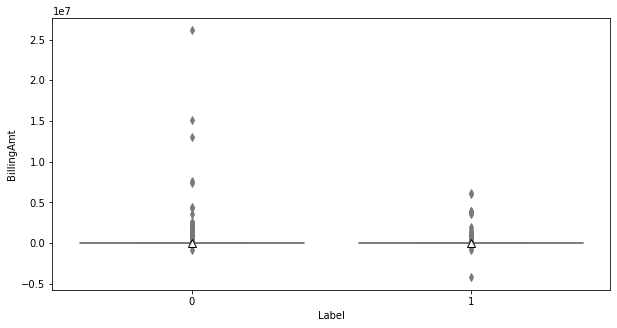

In [43]:
# lets visualize how the target variable (CourseAttemptStatus) corresponds to EFTSL.
box_plt(df1["Label"], df1['BillingAmt'])

In [45]:
# to support above box plot analysis.
df1.groupby(['Label'])['BillingAmt'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,"37,939.00","14,502.22","131,298.31","-914,820.00",735.00,"3,600.00","13,183.50","15,108,481.00"
1,"32,394.00","6,317.78","41,818.14","-825,854.00",214.00,"2,559.00","6,803.00","3,985,048.00"


- From the above we can observe that Bill amount for non bad debt customers is higher, one of the non bad debt customer max billing amount is 15mil.

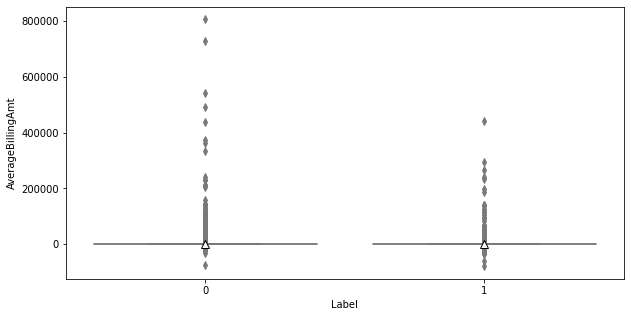

In [44]:
# lets visualize how the target variable (CourseAttemptStatus) corresponds to EFTSL.
box_plt(df1["Label"], df1['AverageBillingAmt'])

In [46]:
# to support above box plot analysis.
df1.groupby(['Label'])['AverageBillingAmt'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,"37,939.00",784.48,"7,749.77","-29,782.00",61.00,167.00,404.00,"805,044.00"
1,"32,394.00",345.79,"4,735.15","-79,384.00",8.00,74.00,140.00,"439,920.00"


- Average bill amount for non bad debt customer is much higher, 50% of the non bad debts customer pay on an average 404 dollars comparing to 140 dollars from bad debts customers.

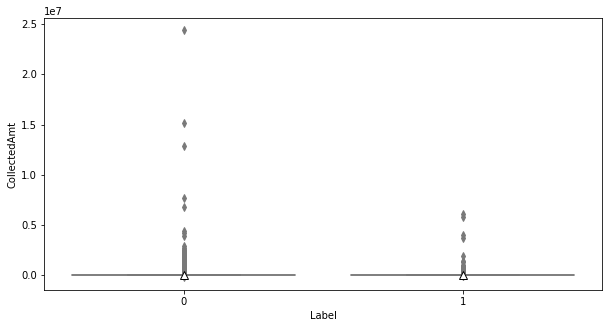

In [45]:
# lets visualize how the target variable (CourseAttemptStatus) corresponds to EFTSL.
box_plt(df1["Label"], df1['CollectedAmt'])

In [47]:
# to support above box plot analysis.
df1.groupby(['Label'])['CollectedAmt'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,"37,939.00","14,562.35","130,437.02","-219,260.00",86.00,"3,309.00","13,600.00","15,108,481.00"
1,"32,394.00","3,665.00","32,271.90","-72,506.00",0.00,0.00,703.00,"3,990,947.00"


- We can obseve that collected amount for non bad debts customers is much higher. 50% of the bad debt customers have not paid any dollars. 

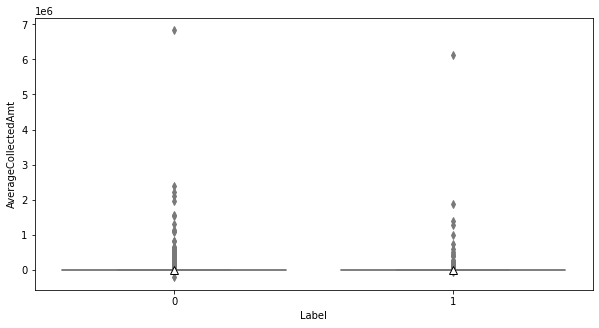

In [47]:
# lets visualize how the target variable (CourseAttemptStatus) corresponds to EFTSL.
box_plt(df1["Label"], df1['AverageCollectedAmt'])

In [39]:
# to support above box plot analysis.
pd.options.display.float_format = '{:,.2f}'.format # to remove scientific notation
df1.groupby(['Label'])['AverageCollectedAmt'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,"37,939.00","3,045.27","45,095.50","-219,260.00",37.00,423.00,"1,458.00","6,828,297.00"
1,"32,394.00",780.73,"13,133.83","-72,506.00",0.00,0.00,100.00,"1,403,564.00"


- We can observe the same trend as Collected amount.

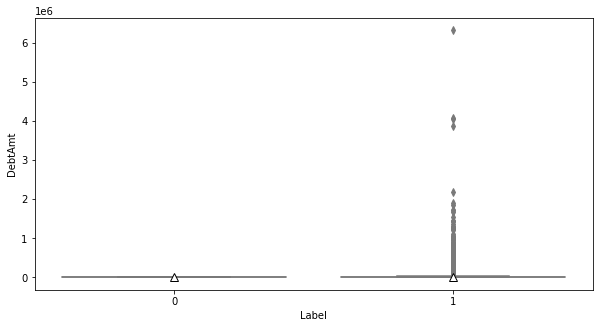

In [48]:
# lets visualize how the target variable (CourseAttemptStatus) corresponds to EFTSL.
box_plt(df1["Label"], df1['DebtAmt'])

In [40]:
# to support above box plot analysis.
pd.options.display.float_format = '{:,.2f}'.format # to remove scientific notation
df1.groupby(['Label'])['DebtAmt'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,"37,939.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,"32,394.00","21,034.90","71,873.11",0.00,197.00,"3,002.00","16,807.50","6,322,610.00"


- Bad debts owes more money. On an averate bad debts customers ows 21k. One of the bad debts customer owes 6million. Non bad debts customers does not owes any money to society.

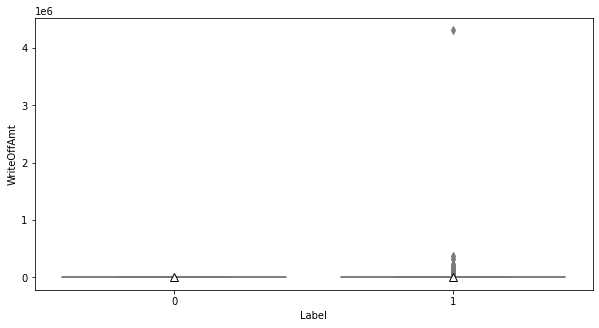

In [49]:
# lets visualize how the target variable (CourseAttemptStatus) corresponds to EFTSL.
box_plt(df1["Label"], df1['WriteOffAmt'])

In [41]:
# to support above box plot analysis.
pd.options.display.float_format = '{:,.2f}'.format # to remove scientific notation
df1.groupby(['Label'])['WriteOffAmt'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,"37,939.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,"32,394.00","1,365.76","24,976.10",0.00,0.00,0.00,0.00,"4,306,605.00"


- There is no write off amount to non bad debts customers, on an average write off amount to bad debts customer is 1365. Max write off amount to bad debts customer is 4million. 

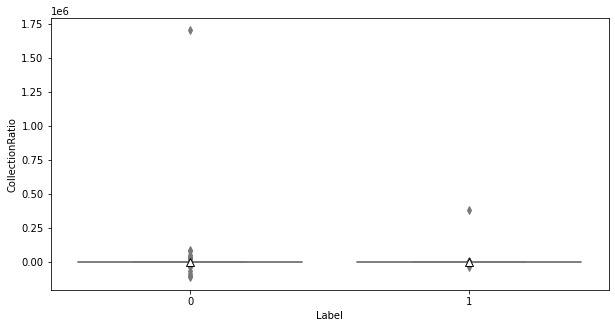

In [50]:
# lets visualize how the target variable (CourseAttemptStatus) corresponds to EFTSL.
box_plt(df1["Label"], df1['CollectionRatio'])

In [42]:
# to support above box plot analysis.
pd.options.display.float_format = '{:,.2f}'.format # to remove scientific notation
df1.groupby(['Label'])['CollectionRatio'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,"37,939.00",45.41,"8,810.81","-115,000.00",0.35,0.99,1.06,"1,701,912.00"
1,"32,394.00",-0.71,223.22,"-40,000.00",0.00,0.00,0.27,"2,325.00"


- We can observe that collection ratio is significantly higher for Non bad debts customers.

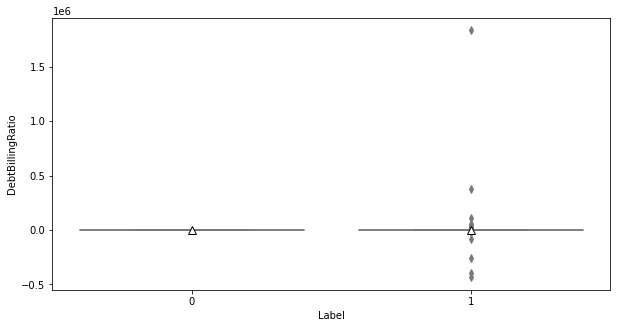

In [54]:
# lets visualize how the target variable (CourseAttemptStatus) corresponds to EFTSL.
box_plt(df1["Label"], df1['DebtBillingRatio'])

In [43]:
# to support above box plot analysis.
pd.options.display.float_format = '{:,.2f}'.format # to remove scientific notation
df1.groupby(['Label'])['DebtBillingRatio'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,"37,939.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,"32,394.00",41.63,"10,836.32","-436,506.00",0.40,1.61,7.10,"1,836,304.00"


- Debt Billing ration we can observe that for Non debt customers is nill, where as for bad debt customers it is significantly higher.

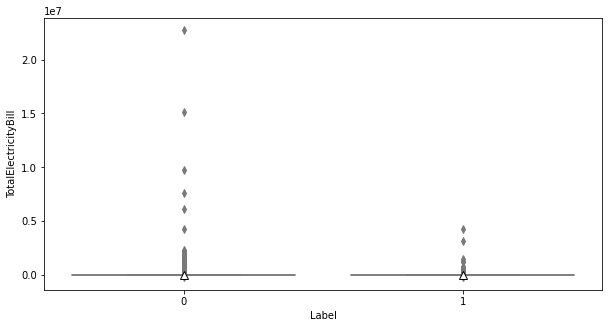

In [53]:
# lets visualize how the target variable (CourseAttemptStatus) corresponds to EFTSL.
box_plt(df1["Label"], df1['TotalElectricityBill'])

In [48]:
# to support above box plot analysis.
pd.options.display.float_format = '{:,.2f}'.format # to remove scientific notation
df1.groupby(['Label'])['TotalElectricityBill'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,"37,939.00","6,552.00","115,019.76","-220,289.00",0.00,0.00,"2,126.00","15,108,481.00"
1,"32,394.00","1,598.64","25,325.55","-172,657.00",0.00,0.00,0.00,"3,198,063.00"


- Total Electricity bill for Non bad debt customers is much higher comparing to bad debts customers. This may be that the society is recovering the money owed to the society in the form of electricity bill, that is the reason we can see that the average electricity bill for non bad debts customers is significanlty higher. Collecting the owed money to the society in the form of electricity bill working out very well to the society.

- We can observe that when the value of the propertysize or the value of the property is higher we hvae 1 or 2 bad debts.

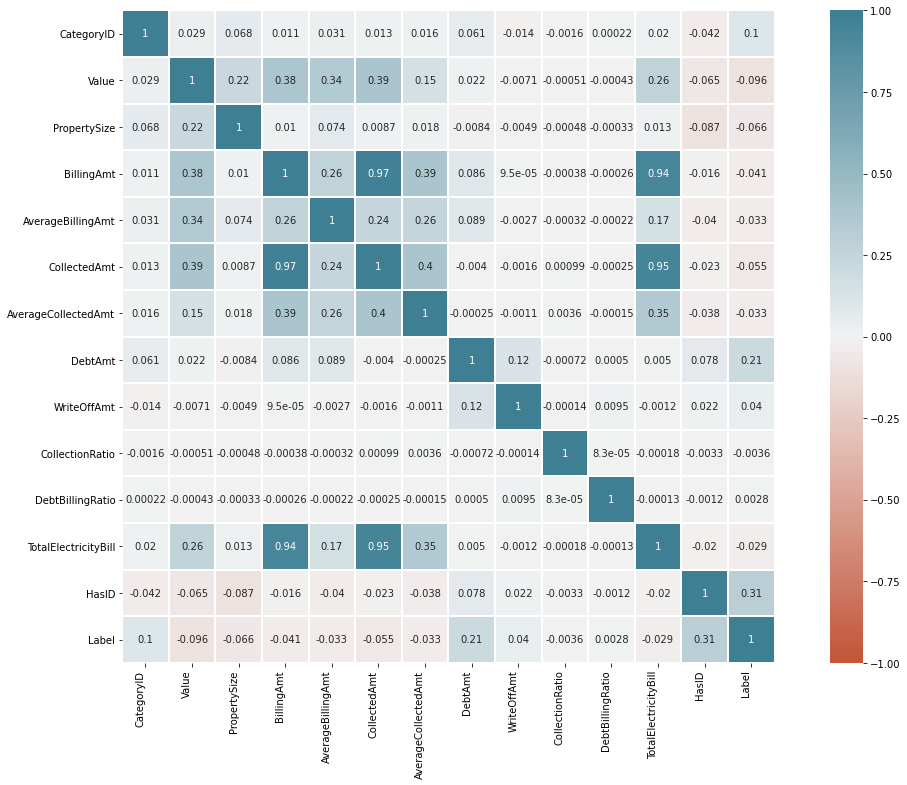

In [79]:
# Apply correlation plot to see if any of the variable are correlated to each other.

plt.figure(figsize=(20,12))
ax = sns.heatmap(df1.dropna().corr(), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200),
                 linecolor='white', linewidths=2, annot = True,square=True)
ax.set_xticklabels( ax.get_xticklabels(), rotation=90, horizontalalignment='right');

- We can observe that Billing Amount and Collected Amount having strong positive relation by 97%.
- Billing amount, Collected amount and Total Electricity bill having strong positive relationship.

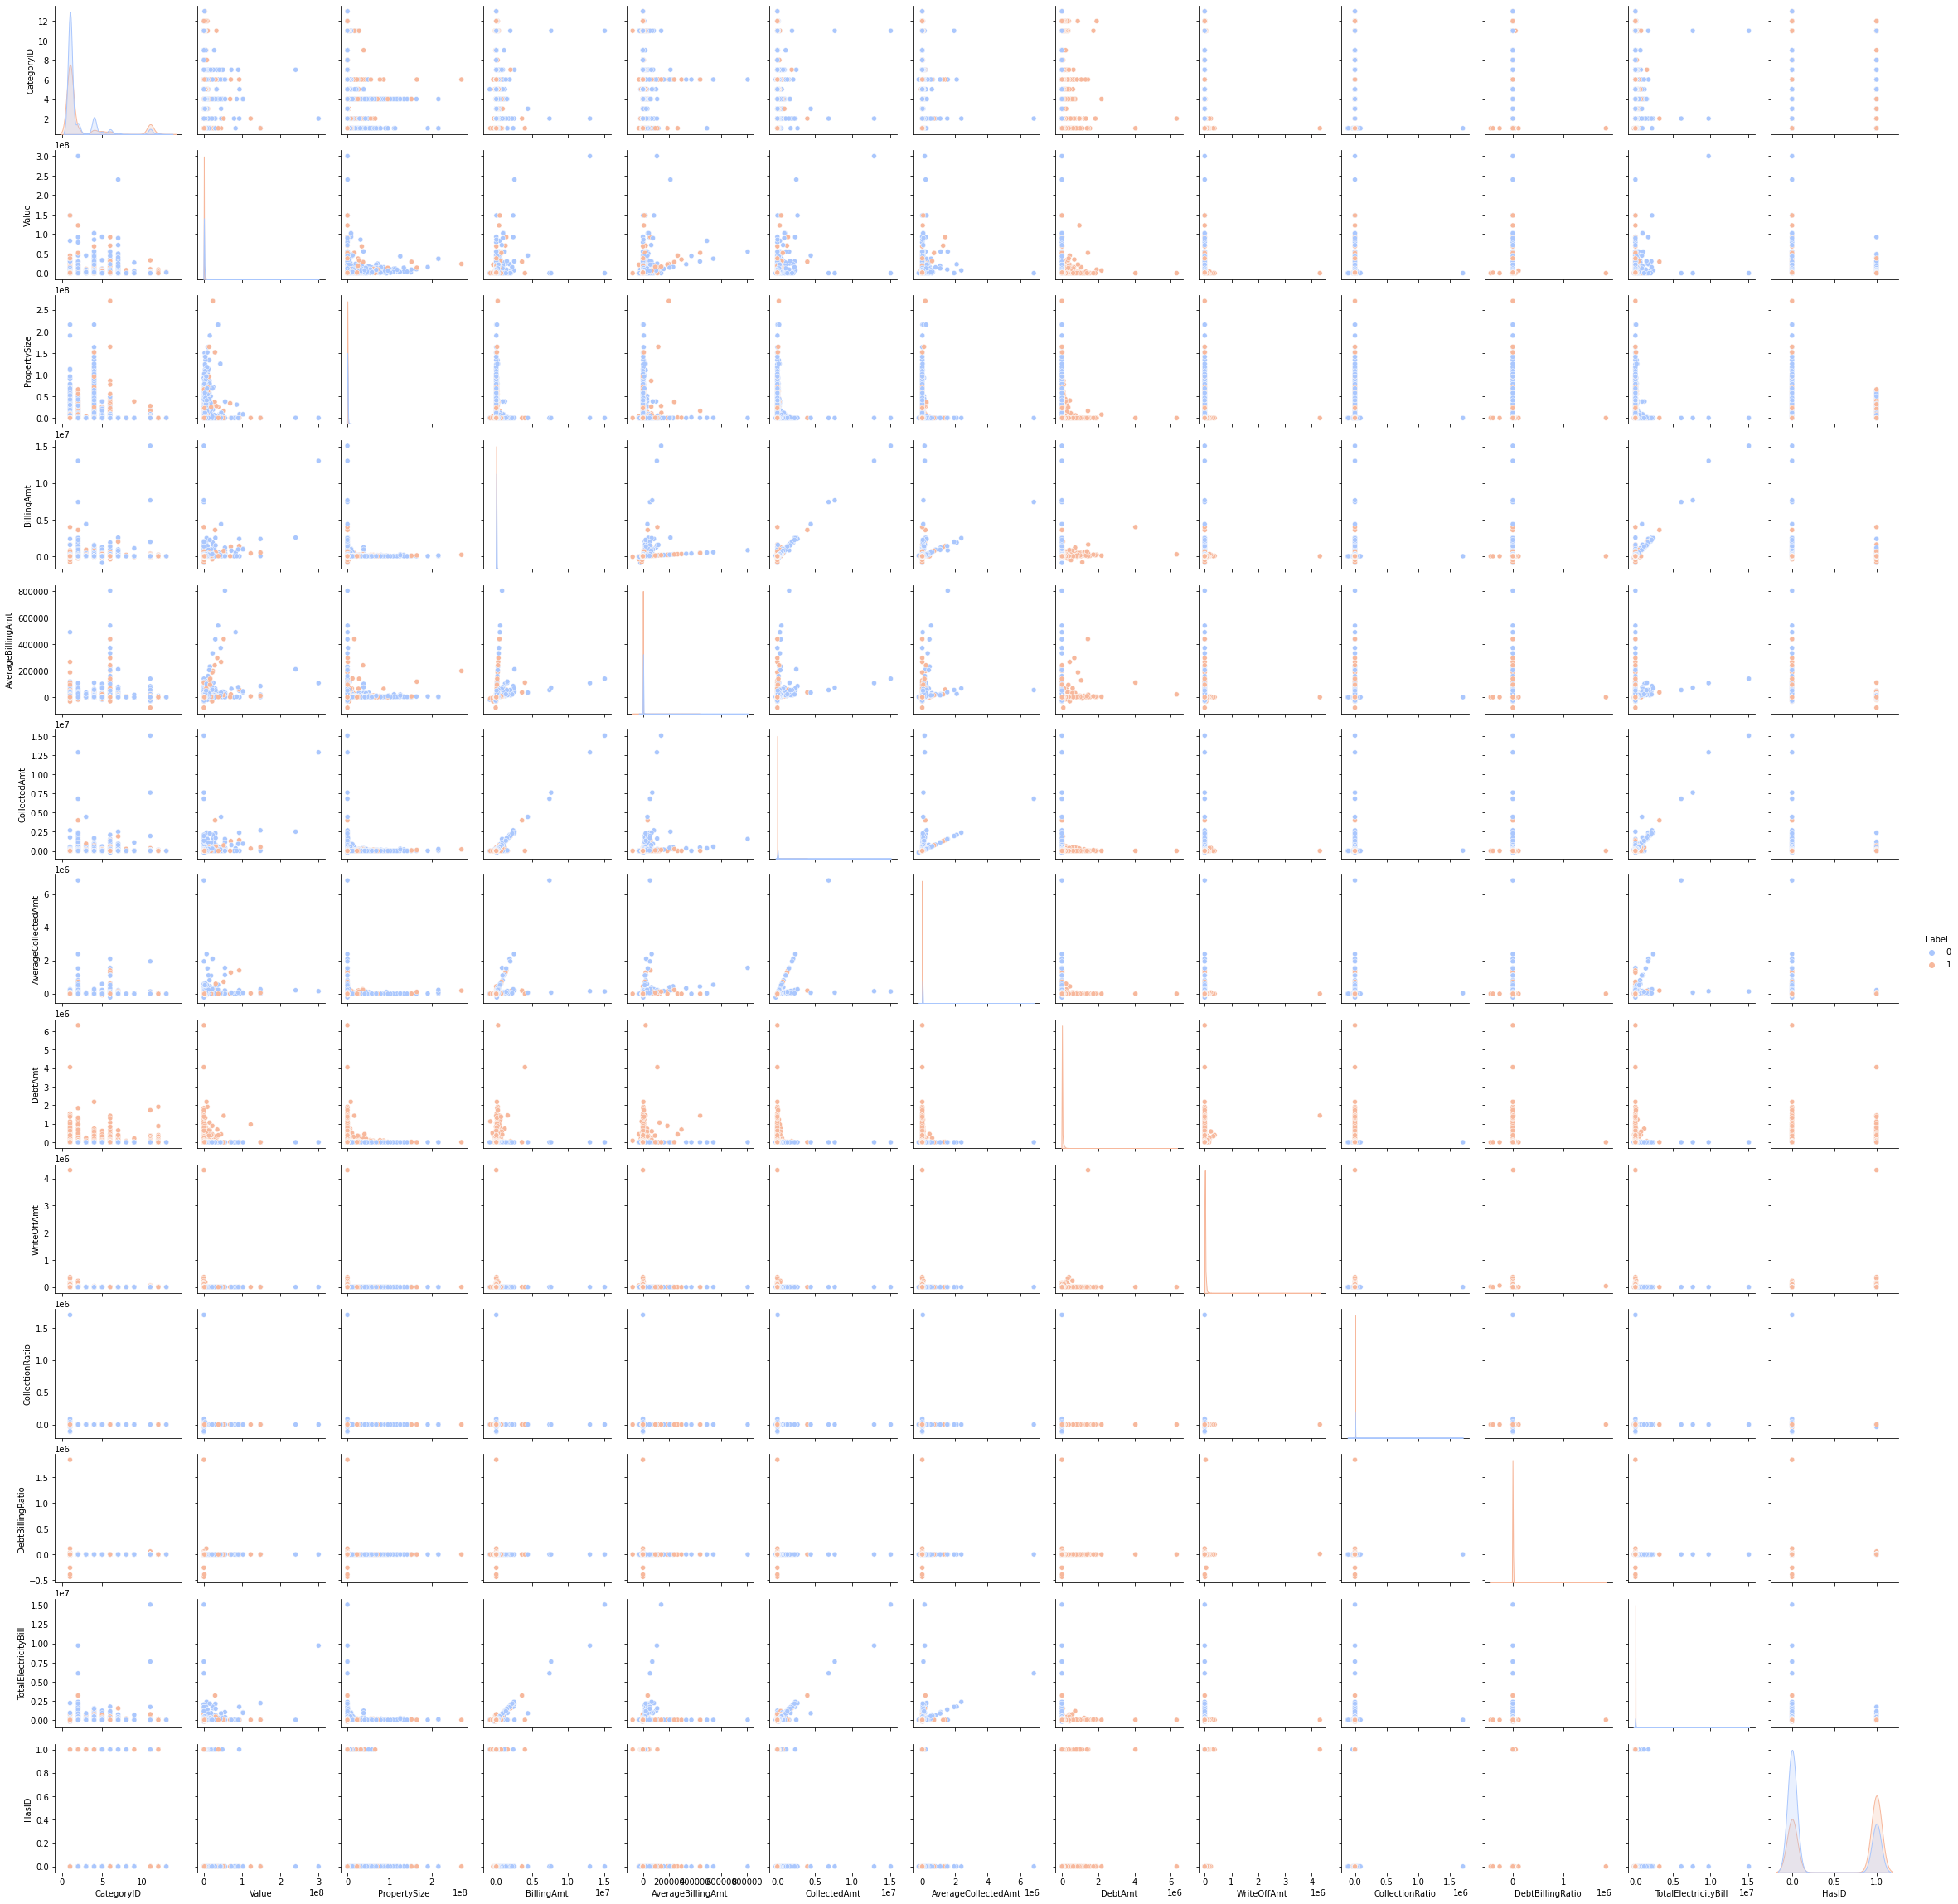

In [84]:
sns.pairplot(df1,hue='Label',palette='coolwarm');

- We can see some positive linear relationship among the variables for both bad debts and non bad debts customers. Some extreme values (outliers) in the data.

---------

# Feature Selection
- **Lasso** involves a penalty factor that determines how many features are retained. Lasso does both parameter shrinkage and variable selection automatically because it zero's out the co-eficients of collinear variables.

In [19]:
# we do not need Catefory as it posses the same info as Category
df2= df1.drop(['Category'], axis=1)

In [110]:
scaled_df=df2.copy()
scaler=MinMaxScaler()
scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)
scaled_df.head()

,CategoryID,Value,PropertySize,BillingAmt,AverageBillingAmt,CollectedAmt,AverageCollectedAmt,DebtAmt,WriteOffAmt,CollectionRatio,DebtBillingRatio,TotalElectricityBill,HasID,Label
0,0.000000,0.006340,0.000002,0.140826,0.090582,0.010682,0.031728,0.000000,0.0,0.063295,0.192056,0.009606,0.0,0.0
1,0.000000,0.000085,0.000001,0.139398,0.089761,0.008938,0.031186,0.000000,0.0,0.063295,0.192056,0.009606,0.0,0.0
2,0.000000,0.001659,0.000002,0.140214,0.090148,0.009937,0.031161,0.000000,0.0,0.063295,0.192056,0.010073,1.0,0.0
3,0.333333,0.000095,0.000000,0.139543,0.089908,0.008916,0.031111,0.001158,0.0,0.063294,0.192056,0.009606,1.0,1.0
4,0.000000,0.000298,0.000000,0.139386,0.089757,0.008935,0.031175,0.000000,0.0,0.063227,0.192056,0.009606,0.0,0.0


In [111]:
# Define X and Y variables

X = scaled_df.drop(['Label'],axis=1)
y = scaled_df['Label']

In [112]:
lasso = LassoCV(cv=10, random_state=42).fit(X, y)

print("Best alpha using built-in LassoCV: %f" %lasso.alpha_)
print("Best score using built-in LassoCV: %f" %lasso.score(X,y))
coef = pd.Series(lasso.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.000076
Best score using built-in LassoCV: 0.145489


In [113]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 6 variables and eliminated the other 7 variables


In [114]:
# Lets check which variables are picked and dropped by Lasso.
# we drop the one wiht 0 coefficient.

imp_coef = coef.sort_values()
imp_coef.sort_values(ascending=False)

DebtAmt                 10.111268
HasID                    0.295285
CategoryID               0.234536
BillingAmt              -0.000000
CollectedAmt            -0.000000
AverageCollectedAmt     -0.000000
WriteOffAmt              0.000000
CollectionRatio         -0.000000
DebtBillingRatio         0.000000
TotalElectricityBill    -0.000000
AverageBillingAmt       -0.186740
PropertySize            -0.746773
Value                   -3.269829
dtype: float64

- We ignore the one with 0 values and we keep the one which contains values.

In [115]:
# get only features which is not equal to 0.

imp_features = pd.Series(imp_coef)
imp_features = imp_features[imp_features != 0] 
imp_features

Value                -3.269829
PropertySize         -0.746773
AverageBillingAmt    -0.186740
CategoryID            0.234536
HasID                 0.295285
DebtAmt              10.111268
dtype: float64

In [116]:
# from above series create a data frame.
imp_feature_df=pd.DataFrame({'Feature_name':imp_features.index, 'Feature_value':imp_features.values})

# sort by highest feature value to lowest.
imp_feature_df.sort_values(ascending=False,by='Feature_value',inplace=True)
imp_feature_df

,Feature_name,Feature_value
5,DebtAmt,10.111268
4,HasID,0.295285
3,CategoryID,0.234536
2,AverageBillingAmt,-0.186740
1,PropertySize,-0.746773
0,Value,-3.269829


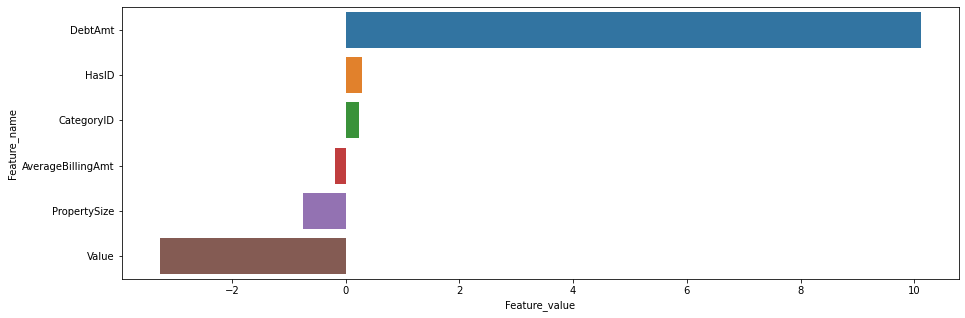

In [117]:
# apply diverging bar chart for data frame.

plt.figure(figsize=(15,5))
ax=sns.barplot(x='Feature_value',y='Feature_name',data=imp_feature_df,ci=None)
ax.set_xlabel('Feature_value');

- From the above, we can observe that DebtAmt is one of the positive features which influences Bad debt significantly. The value of the property and Property size will negatively affect the bad debt. HasID, CategoryID and Average bill amount will have little effect on the bad debt.

In [119]:
# get the list of important features.
imp_feature_df['Feature_name'].unique()

array(['DebtAmt', 'HasID', 'CategoryID', 'AverageBillingAmt',
       'PropertySize', 'Value'], dtype=object)

In [21]:
# data frame with important features only.

df3=df2[['DebtAmt', 'HasID', 'CategoryID', 'AverageBillingAmt',
       'PropertySize', 'Value','Label']]
df3.head()

,DebtAmt,HasID,CategoryID,AverageBillingAmt,PropertySize,Value,Label
0,0,0,1,729,585,2674700,0
1,0,0,1,3,315,36000,0
2,0,1,1,345,528,700000,0
3,7319,1,5,133,0,40000,1
4,0,0,1,0,0,125800,0


----------------

# Evaluation Metrics

* **True Positive:**
     - Reality: Is not a bad debt customer
     - Model predicted: Is not a bad debt customer.
     - Outcome: The actual value was positive, and the model predicted a positive value. The model is good.
     
* **True Negative:**
     - Reality: Is a bad debt customer
     - Model predicted: Is a bad debt customer.
     - Outcome: The actual value was negative, and the model predicted a negative value. The model is good.
     
* **False Positive:**
     - Reality: Customer or Property WILL NOT become bad debt.
     - Model predicted: Customer or Property WILL become bad debt.
     - Outcome: The Financial Institution which is targeting the potential customers (bad debt customers) will be wasting their time and resources on the customers who WILL NOT become bad debt, which will leads to high marketing and operational cost.
     
* **False Negative:**
     - Reality:  Customer or Property WILL become bad debt.
     - Model predicted: Customer or Property WILL NOT become bad debt.
     - Outcome: The potential customer (bad debt) is missed by the by the financial institution, If the financial institution correctly identified the bad debt customers we could have offered them some previliges or any other form of payment method to not to become bad debt or recover minimum money owed to the council. This will leads to direct loss to the council and financial institution.

* **Which Loss is greater**
- Property  becoming a bad debt is a more significant loss for the company, The bad debt and stressed assets result in a liquidity crunch and impact the banks that are lenders to both developers and property buyers.
     
* **How to reduce this loss i.e need to reduce False Negatives?**
- Financial Institution wants **RECALL** to be maximized i.e. we need reduce the number of false negatives. Therefore,we use Recall as our metrics.

-----------

# Model Building

In [22]:
# view the data
df3.head()

,DebtAmt,HasID,CategoryID,AverageBillingAmt,PropertySize,Value,Label
0,0,0,1,729,585,2674700,0
1,0,0,1,3,315,36000,0
2,0,1,1,345,528,700000,0
3,7319,1,5,133,0,40000,1
4,0,0,1,0,0,125800,0


In [23]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision

def get_metrics_score(model, flag=True):
    """
    model : classifier to predict values of X

    """
    # defining an empty list to store train and test results
    score_list = []

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    train_recall = metrics.recall_score(y_train, pred_train)
    test_recall = metrics.recall_score(y_test, pred_test)

    train_precision = metrics.precision_score(y_train, pred_train)
    test_precision = metrics.precision_score(y_test, pred_test)
    
    train_f1 = metrics.f1_score(y_train, pred_train)
    test_f1 = metrics.f1_score(y_test, pred_test)

    score_list.extend((train_acc, test_acc, train_recall, test_recall, train_precision, test_precision, train_f1, test_f1))

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ", model.score(X_train, y_train))
        print("Accuracy on test set : ", model.score(X_test, y_test))
        print("Recall on training set : ", metrics.recall_score(y_train, pred_train))
        print("Recall on test set : ", metrics.recall_score(y_test, pred_test))
        print("Precision on training set : ", metrics.precision_score(y_train, pred_train))
        print("Precision on test set : ", metrics.precision_score(y_test, pred_test))
        print("f1 on training set : ", metrics.f1_score(y_train, pred_train))
        print("f1 on test set : ", metrics.f1_score(y_test, pred_test))


    return score_list  # returning the list with train and test scores

In [24]:
## Function to create confusion matrix

def make_confusion_matrix(model, y_actual, labels=[1, 0]):
    """
    model : classifier to predict values of X
    y_actual : ground truth

    """
    y_predict = model.predict(X_test)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    data_cm = pd.DataFrame(
        cm,
        index=[i for i in ["Actual - No", "Actual - Yes"]],
        columns=[i for i in ["Predicted - No", "Predicted - Yes"]],
    )
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(8, 5))
    sns.heatmap(data_cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")  
    
def make_confusion_matrix(model, y_actual, labels=[1, 0]):
    """
    model : classifier to predict values of X
    y_actual : ground truth

    """
    y_predict = model.predict(X_test)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    data_cm = pd.DataFrame(
        cm,
        index=[i for i in ["Actual - No", "Actual - Yes"]],
        columns=[i for i in ["Predicted - No", "Predicted - Yes"]],
    )
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(8, 5))
    sns.heatmap(data_cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


In [25]:
# Defining X and Y variables

X = df3.drop(['Label'],axis=1)
y = df3['Label']

In [26]:
# Splitting data into training and test set:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)

(70333, 6) (30143, 6)


### Building basic models.
- Building basic models will help us understand which  model will perform better, how much tuning needed from the default parameters to reduce or increase the model complexity and also we can use this basic models as a benchmark to improve the model performance.

In [126]:
models = []  # Empty list to store all the models

# Appending pipelines for each model into the list

models.append(
    (
        "GNB",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("gnb", GaussianNB()),
            ]
        ),
    )
)


models.append(
    (
        "SGD",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("sgd", SGDClassifier(random_state=42,  class_weight='balanced')),
            ]
        ),
    )
)

models.append(
    (
        "SVM",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("svm", svm.SVC(random_state=42,  class_weight='balanced', probability=True)),
            ]
        ),
    )
)

models.append(
    (
        "Ridge",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("ridge", RidgeClassifier(random_state=42, max_iter=1000, class_weight='balanced')),
            ]
        ),
    )
)

models.append(
    (
        "LGBM",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("lgbm", LGBMClassifier(random_state=42,  class_weight='balanced')),
            ]
        ),
    )
)


models.append(
    (
        "XTREE",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("xtree", ExtraTreesClassifier(random_state=42,  class_weight='balanced', bootstrap=True)),
            ]
        ),
    )
)

models.append(
    (
        "CATB",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("catb", CatBoostClassifier(random_state=42,  verbose=False)),
            ]
        ),
    )
)

models.append(
    (
        "KNN",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("knn", KNeighborsClassifier()),
            ]
        ),
    )
)

models.append(
    (
        "LG",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("lg", LogisticRegression(random_state=42, class_weight='balanced')),
            ]
        ),
    )
)


models.append(
    (
        "DTREE",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("decision_tree", DecisionTreeClassifier(random_state=42, class_weight='balanced')),
            ]
        ),
    )
)


models.append(
    (
        "Bagging",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("bg", BaggingClassifier(random_state=42)),
            ]
        ),
    )
)


models.append(
    (
        "RF",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("random_forest", RandomForestClassifier(random_state=42, class_weight='balanced')),
            ]
        ),
    )
)

models.append(
    (
        "ADB",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("adaboost", AdaBoostClassifier(random_state=42)),
            ]
        ),
    )
)


models.append(
    (
        "GBM",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("gradient_boosting", GradientBoostingClassifier(random_state=42)),
            ]
        ),
    )
)


models.append(
    (
        "XGB",
        Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("xgboost", XGBClassifier(random_state=42, eval_metric='logloss')),
            ]
        ),
    )
)

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=42
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

GNB: 75.28421360475652
SGD: 59.54764342426008
SVM: 67.16173799018624
Ridge: 65.58098341213945
LGBM: 95.99729624448597
XTREE: 95.07287250166702
CATB: 95.6983985648969
KNN: 86.58981607578491
LG: 66.11406477476577
DTREE: 96.10512505284667
Bagging: 95.64293098491949
RF: 95.84321826191011
ADB: 90.66648831533719
GBM: 93.92659363124336
XGB: 95.74770281667708


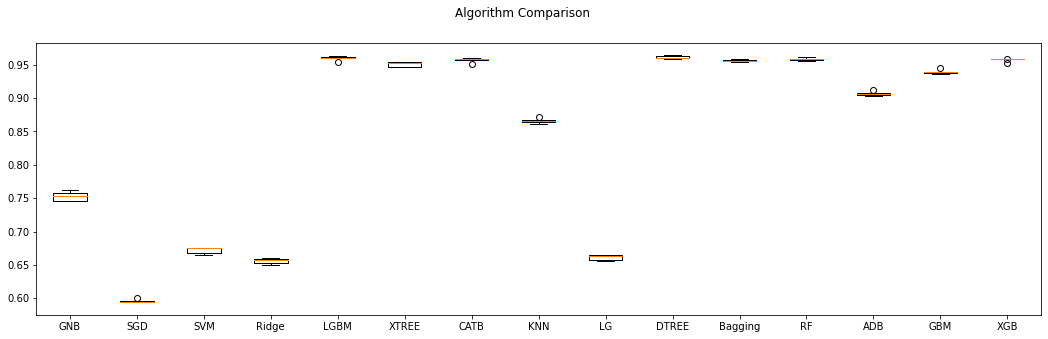

In [127]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(18, 5))
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

- All regressions and SVM model produced low model performance score. Tree based model, Bagging and Boosting produced very good model performance score. Naive Bayes model produce decent model performance score.
- To improve the score of the regression model, we have to transform non linear features to linear features using power transformation.
- For tree based, bagging and Boosting models we have to reduce the model complexity, otherwise it will overfit.

- **Note - Ealier without feature selection all the tree based, Bagging and Boosting were (Overfitting) precision.**

## GridSearch (Hyper Parameter tuning)

In [27]:
# function to create execution time for grid seach and random search models.

def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    return f"{h}:{m}:{s}"

In [28]:
# Defining X and Y variables

X = df3.drop(['Label'],axis=1)
y = df3['Label']

In [29]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)

(70333, 6) (30143, 6)


### Naive Bayes GridSearch

In [131]:
import time
start_base = time.time() # to check execution time

# define model
pipe = make_pipeline(MinMaxScaler(), GaussianNB())

param_grid = {#'gaussiannb__var_smoothing': np.logspace(0,-9, num=100) 
              'gaussiannb__var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-9]
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)

# Fitting parameters in GridSeachCV

grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base, end_base)

print("GaussianNB GridSearch execution time is {a}".format(a=execution_time))
print("Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_))

GaussianNB GridSearch execution time is 0:0:6
Best Parameters:{'gaussiannb__var_smoothing': 1e-13} 
Score: 0.85495945703471


In [30]:
# Creating new pipeline with best parameters
gnb_gridsearch = make_pipeline(MinMaxScaler(),
                                         GaussianNB(var_smoothing= 1e-13))
# Fit the model on training data
gnb_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('gaussiannb', GaussianNB(var_smoothing=1e-13))])

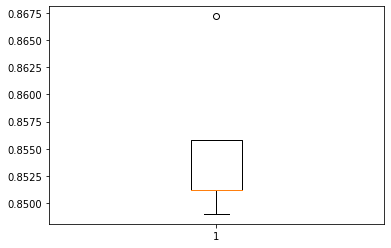

In [133]:
# Let's evaluate the model performance by using KFold and cross_val_score
# K-Folds cross-validator provides dataset indices to split data into train/validation sets. 
# Split dataset into k consecutive stratified folds (without shuffling by default).
#Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scorer='recall'

kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)     #Setting number of splits equal to 5
cv_result_bfr=cross_val_score(estimator=gnb_gridsearch, X=X_train, y=y_train, scoring=scorer, cv=kfold)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance onthe training data varies between 0.85 to .8675.

Accuracy on training set :  0.9330470760524932
Accuracy on test set :  0.9320240188435126
Recall on training set :  0.85489785227868
Recall on test set :  0.8526853116687038
Precision on training set :  1.0
Precision on test set :  1.0
f1 on training set :  0.9217735103078227
f1 on test set :  0.9204858550972098


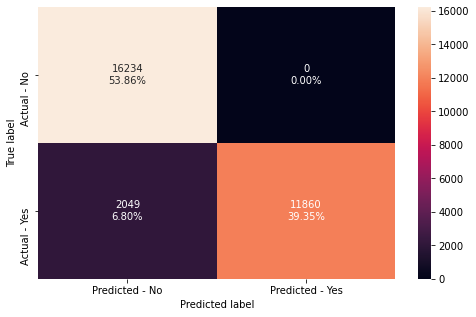

In [31]:
# Calculating different metrics
gnb_gridsearch_score=get_metrics_score(gnb_gridsearch)

# Creating confusion matrix
make_confusion_matrix(gnb_gridsearch, y_test)

- Good model score, however Precision overfits the test data.

### DecisionTree GridSearch

In [153]:
import time
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(MinMaxScaler(), DecisionTreeClassifier(random_state=42, class_weight='balanced'))

# Parameter grid to pass in GridSearchCV
param_grid = {
    "decisiontreeclassifier__criterion": ['gini','entropy'],  
    "decisiontreeclassifier__max_depth": [6, 8, None],  
    "decisiontreeclassifier__min_samples_split": [ 2, 4, 7],#  geater range will have marginal increase with the comoputation cost.
    "decisiontreeclassifier__min_samples_leaf":[1, 2, 5, 7], # higher range will under fit. < less than 5 should be good enough.
    "decisiontreeclassifier__min_impurity_decrease":[0.001, 0.01, 0.1]} # loweing beyong 0.0001 training overfits. 
# increasing greater than 0.01 underfits. 

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)
end_base = time.time()
execution_time = exec_time(start_base, end_base)

print("DecsionTree GridSearch execution time is {a}".format(a=execution_time))
print("Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_))

DecsionTree GridSearch execution time is 0:0:50
Best Parameters:{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__min_impurity_decrease': 0.001, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2} 
Score: 0.9486955332959279


In [32]:
# Creating new pipeline with best parameters
dtree_gridsearch = make_pipeline(
    MinMaxScaler(),
    DecisionTreeClassifier(random_state=42, class_weight='balanced', criterion='entropy', max_depth=8,
                           min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2))

# Fit the model on training data
dtree_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=8,
                                        min_impurity_decrease=0.001,
                                        random_state=42))])

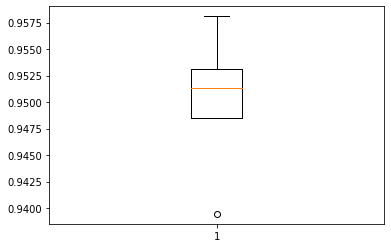

In [155]:
# Let's evaluate the model performance by using KFold and cross_val_score

scoring='recall'

kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)     #Setting number of splits equal to 5
cv_result_bfr=cross_val_score(estimator=dtree_gridsearch, X=X_train, y=y_train, scoring=scoring, cv=kfold)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.94 to 0.9575.

Accuracy on training set :  0.9612415224716705
Accuracy on test set :  0.9599907109444978
Recall on training set :  0.9544572150494561
Recall on test set :  0.9513983751527788
Precision on training set :  0.9612699003817149
Precision on test set :  0.9614909540071206
f1 on training set :  0.9578514441214669
f1 on test set :  0.9564180398959238


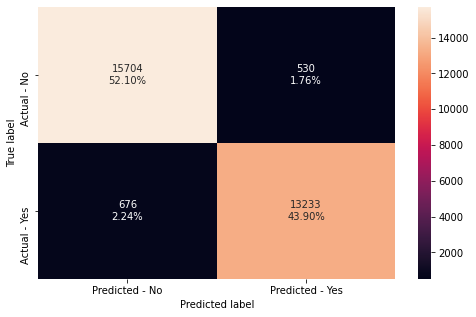

In [33]:
# Calculating different metrics
dtree_gridsearch_score=get_metrics_score(dtree_gridsearch)

# Creating confusion matrix
make_confusion_matrix(dtree_gridsearch, y_test)

- Good model performance score.

### RandomForest GridSearch

In [157]:
import time
start_base = time.time() # to check execution time
# Creating pipeline
pipe = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=42, oob_score=True,bootstrap=True,
                                                              class_weight='balanced'))
# Parameter grid to pass in GridSearchCV
param_grid = {"randomforestclassifier__criterion": ["gini", "entropy"],
              "randomforestclassifier__max_depth": [8, 10, 12], 
              "randomforestclassifier__max_features": [0.7, 0.8, 1], 
              #"randomforestclassifier__max_features": ['sqrt','log2','auto'],
              #"randomforestclassifier__min_samples_split": [1, 3, 5,],
              #"randomforestclassifier__min_samples_leaf": [1, 3, 5], 
              "randomforestclassifier__n_estimators": [200, 300, 400]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base, end_base)

print("RandomForest GridSearch execution time is {a}".format(a=execution_time))
print("Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_))

RandomForest GridSearch execution time is 0:25:22
Best Parameters:{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 12, 'randomforestclassifier__max_features': 0.7, 'randomforestclassifier__n_estimators': 300} 
Score: 0.9589866964389977


In [34]:
# Creating new pipeline with best parameters
rf_gridsearch = make_pipeline(
    MinMaxScaler(),
    RandomForestClassifier(random_state=42, oob_score=True, bootstrap=True, class_weight='balanced',criterion='gini', max_depth=12,
                           max_features= 0.7, n_estimators=300))

# Fit the model on training data
rf_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=12,
                                        max_features=0.7, n_estimators=300,
                                        oob_score=True, random_state=42))])

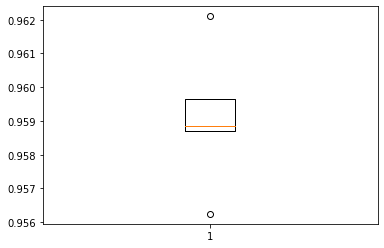

In [159]:
# Let's evaluate the model performance by using KFold and cross_val_score

scoring='recall'

kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)     #Setting number of splits equal to 10
cv_result_bfr=cross_val_score(estimator=rf_gridsearch, X=X_train, y=y_train, scoring=scoring, cv=kfold)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on the training data varies between 0.956 to 0.962.

Accuracy on training set :  0.9707249797392404
Accuracy on test set :  0.9658295458315364
Recall on training set :  0.9655193664684313
Recall on test set :  0.957581422100798
Precision on training set :  0.9708743880523022
Precision on test set :  0.9680209317537611
f1 on training set :  0.9681894727084525
f1 on test set :  0.962772878415498


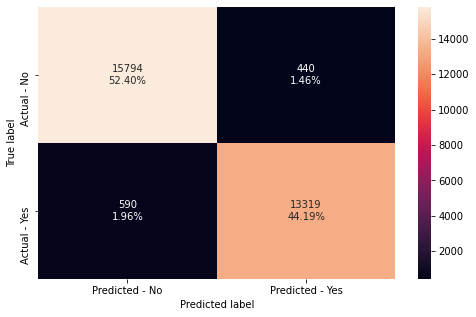

In [35]:
# Calculating different metrics
rf_gridsearch_score=get_metrics_score(rf_gridsearch)

# Creating confusion matrix
make_confusion_matrix(rf_gridsearch, y_test)

- Good model performance score.

### LightGBM GridSearch

In [135]:
import time
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(
    MinMaxScaler(), LGBMClassifier(random_state=42, objective='binary'))

# Parameter grid to pass in GridSearchCV
param_grid = {
    "lgbmclassifier__max_depth": [6, 8, 10],
    "lgbmclassifier__num_leaves": np.arange(20, 80, 20), 
    "lgbmclassifier__min_data_in_leaf": [500, 700, 900], 
    "lgbmclassifier__learning_rate": [0.2, 0.4, 0.6]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base, end_base)

print("LGBM GridSearch execution time is {a}".format(a=execution_time))
print("Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_))

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
LGBM GridSearch execution time is 0:1:29
Best Parameters:{'lgbmclassifier__learning_rate': 0.6, 'lgbmclassifier__max_depth': 10, 'lgbmclassifier__min_data_in_leaf': 700, 'lgbmclassifier__num_leaves': 60} 
Score: 0.9590176364984473


In [36]:
# Creating new pipeline with best parameters

lightgbm_gridsearch = make_pipeline(
    MinMaxScaler(),
    LGBMClassifier(random_state=42, objective='binary', max_depth= 10, min_data_in_leaf= 700, learning_rate=0.6,
                   num_leaves=60))

# Fit the model on training data
lightgbm_gridsearch.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.6, max_depth=10,
                                min_data_in_leaf=700, num_leaves=60,
                                objective='binary', random_state=42))])

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700


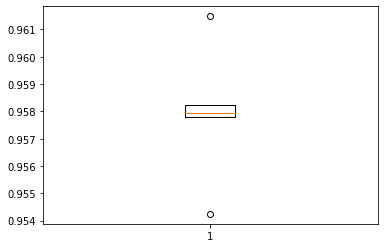

In [137]:
# Let's evaluate the model performance by using KFold and cross_val_score
# K-Folds cross-validator provides dataset indices to split data into train/validation sets. 
# Split dataset into k consecutive stratified folds (without shuffling by default).
#Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scorer='recall'

kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)     #Setting number of splits equal to 5
cv_result_bfr=cross_val_score(estimator=lightgbm_gridsearch, X=X_train, y=y_train, scoring=scorer, cv=kfold)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.954 to 0.961.

Accuracy on training set :  0.9791278631652283
Accuracy on test set :  0.966758451381747
Recall on training set :  0.9745169938064278
Recall on test set :  0.9565748795743763
Precision on training set :  0.9801345027427403
Precision on test set :  0.9709552652703788
f1 on training set :  0.9773176761433868
f1 on test set :  0.9637114298131246


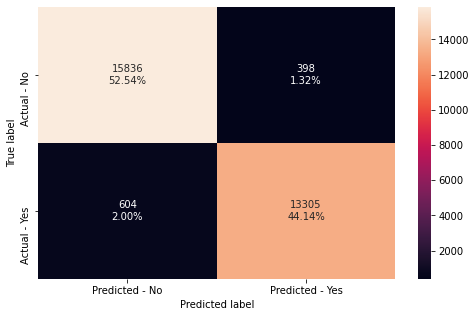

In [37]:
# Calculating different metrics
light_gbm_gridsearch_score = get_metrics_score(lightgbm_gridsearch)

# Creating confusion matrix
make_confusion_matrix(lightgbm_gridsearch, y_test)

- Good model performance scores.

### ExtraTree GridSearch

In [139]:
import time
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(MinMaxScaler(), ExtraTreesClassifier(random_state=42, class_weight='balanced', bootstrap=True, oob_score=True))

# Parameter grid to pass in GridSearchCV
param_grid = {
    "extratreesclassifier__criterion": ['gini','entropy'],  
    "extratreesclassifier__max_depth": [6, 8, 10], 
    #"extratreesclassifier__min_samples_split": [ 2, 4, 7, 10],#  geater range will have marginal increase with the comoputation cost.
    #"extratreesclassifier__min_samples_leaf":[1, 2, 5, 7,10], # higher range will under fit. < less than 5 should be good enough.
    "extratreesclassifier__min_impurity_decrease":[0.0001, 0.001, 0.01, 0.1]} # loweing beyong 0.0001 training overfits. 
# increasing greater than 0.01 underfits. 

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base, end_base)

print("ExtraTree GridSearch execution time is {a}".format(a=execution_time))
print("Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_))

ExtraTree GridSearch execution time is 0:1:12
Best Parameters:{'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__max_depth': 6, 'extratreesclassifier__min_impurity_decrease': 0.1} 
Score: 0.8


In [38]:
# Creating new pipeline with best parameters
extra_tree_gridsearch = make_pipeline(
    MinMaxScaler(),
    ExtraTreesClassifier(random_state=42, class_weight='balanced', bootstrap=True, oob_score=True, criterion='gini', max_depth=6,
                           min_impurity_decrease=0.1))
# Fit the model on training data
extra_tree_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=True, class_weight='balanced',
                                      max_depth=6, min_impurity_decrease=0.1,
                                      oob_score=True, random_state=42))])

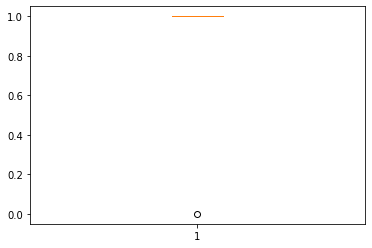

In [141]:
# Let's evaluate the model performance by using KFold and cross_val_score
# K-Folds cross-validator provides dataset indices to split data into train/validation sets. 
# Split dataset into k consecutive stratified folds (without shuffling by default).
#Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scorer='recall'

kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)     #Setting number of splits equal to 5
cv_result_bfr=cross_val_score(estimator=extra_tree_gridsearch, X=X_train, y=y_train, scoring=scorer, cv=kfold)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Training data not able to produce good score.

Accuracy on training set :  0.5385807515675429
Accuracy on test set :  0.5385661679328534
Recall on training set :  0.0
Recall on test set :  0.0
Precision on training set :  0.0
Precision on test set :  0.0
f1 on training set :  0.0
f1 on test set :  0.0


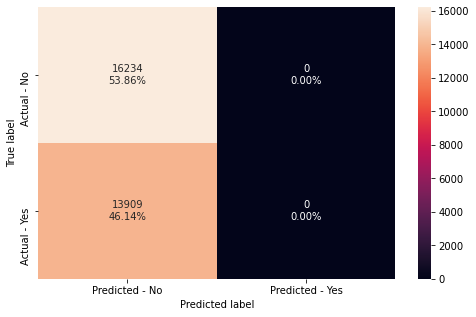

In [39]:
# Calculating different metrics
extra_tree_gridsearch_score=get_metrics_score(extra_tree_gridsearch)
# Creating confusion matrix
make_confusion_matrix(extra_tree_gridsearch, y_test)

- Not a good model. Model not able to identify TN and FP.

### CatBoost GridSearch

In [143]:
import time
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(
    MinMaxScaler(), CatBoostClassifier(random_state=42, verbose=False))

# Parameter grid to pass in GridSearchCV
param_grid = {
    "catboostclassifier__depth": [8, 10, 12], 
    "catboostclassifier__l2_leaf_reg": [1, 3, 5], 
    "catboostclassifier__learning_rate": [0.001, 0.01, 0.05],
    "catboostclassifier__iterations": [25, 50, 80]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base, end_base)

print("CatBoost GridSearch execution time is {a}".format(a=execution_time))
print("Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_))

CatBoost GridSearch execution time is 0:0:60
Best Parameters:{'catboostclassifier__depth': 10, 'catboostclassifier__iterations': 50, 'catboostclassifier__l2_leaf_reg': 1, 'catboostclassifier__learning_rate': 0.05} 
Score: 0.9368625792370271


In [41]:
# Creating new pipeline with best parameters

catboost_gridsearch = make_pipeline(
    MinMaxScaler(),
    CatBoostClassifier(random_state=42, verbose=False, max_depth= 10, iterations=50, l2_leaf_reg=1,
                  learning_rate=0.05))

# Fit the model on training data
catboost_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000001C2DAF09C40>)])

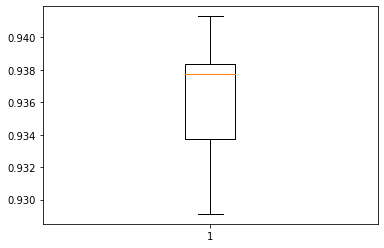

In [145]:
# Let's evaluate the model performance by using KFold and cross_val_score
# K-Folds cross-validator provides dataset indices to split data into train/validation sets. 
# Split dataset into k consecutive stratified folds (without shuffling by default).
#Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='recall'

kfold=StratifiedKFold(n_splits=5, shuffle=True,random_state=1)     #Setting number of splits equal to 5
cv_result_bfr=cross_val_score(estimator=catboost_gridsearch, X=X_train, y=y_train, scoring=scoring, cv=kfold)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.930 to 0.940.

Accuracy on training set :  0.9610140332418637
Accuracy on test set :  0.9593272069800617
Recall on training set :  0.9388654361692294
Recall on test set :  0.9352217988352866
Precision on training set :  0.9757261344349442
Precision on test set :  0.9756243906097652
f1 on training set :  0.9569409547738694
f1 on test set :  0.9549959621173189


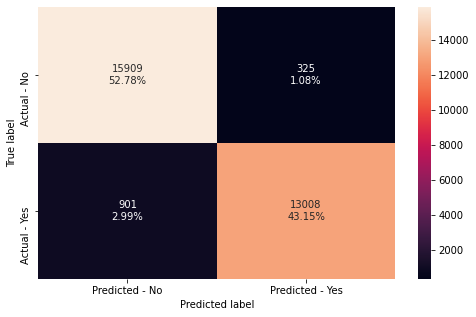

In [42]:
# Calculating different metrics
catb_gridsearch_score = get_metrics_score(catboost_gridsearch)

# Creating confusion matrix
make_confusion_matrix(catboost_gridsearch, y_test)

- Model produced good score.

### KNN GrisSearch

In [149]:
import time
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

# Parameter grid to pass in GridSearchCV
param_grid = {
    "kneighborsclassifier__n_neighbors": [1, 3, 5, 7], 
    "kneighborsclassifier__leaf_size": [10, 20 ,30],
    #"kneighborsclassifier__weights": ['uniform', 'distance'],
     "kneighborsclassifier__algorithm": ['auto','kd_tree','brute'], 
     "kneighborsclassifier__p": [5, 10, 15] 
    # "kneighborsclassifier__metric": ['euclidean','manhattan','minkowski']],
    }

  #"kneighborsclassifier__n_neighbors": np.arange(1, 20,5), 
  #  "kneighborsclassifier__leaf_size": np.arange(20, 100, 20),
    #"kneighborsclassifier__weights": ['uniform', 'distance'],
  #   "kneighborsclassifier__algorithm": ['auto','kd_tree','brute'], 
   #  "kneighborsclassifier__p": np.arange(1, 20, 5) 
    # "kneighborsclassifier__metric": ['euclidean','manhattan','minkowski']],
    
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base, end_base)

print("KNN GridSearch execution time is {a}".format(a=execution_time))
print("Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_))

KNN GridSearch execution time is 1:46:31
Best Parameters:{'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__leaf_size': 10, 'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__p': 15} 
Score: 0.8924903187709041


In [43]:
# Creating new pipeline with best parameters

knn_gridsearch = make_pipeline(
    MinMaxScaler(),
    KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=1, p=15))

# Fit the model on training data
knn_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(leaf_size=10, n_neighbors=1, p=15))])

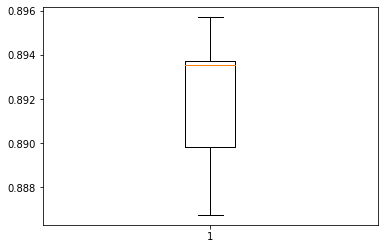

In [151]:
# Let's evaluate the model performance by using KFold and cross_val_score

scoring='recall'

kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)     #Setting number of splits equal to 5
cv_result_bfr=cross_val_score(estimator=knn_gridsearch, X=X_train, y=y_train, scoring=scoring, cv=kfold)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on the training data varies between 0.888 to 0.896.

Accuracy on training set :  0.997383873857222
Accuracy on test set :  0.9120525495139833
Recall on training set :  0.9969494345669121
Recall on test set :  0.894816305988928
Precision on training set :  0.9973796972779678
Precision on test set :  0.9128648965820743
f1 on training set :  0.9971645195093386
f1 on test set :  0.9037504992194024


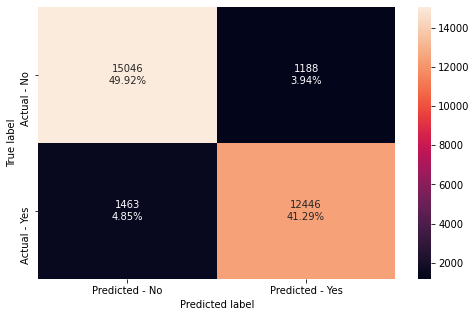

In [44]:
# Calculating different metrics
knn_gridsearch_score = get_metrics_score(knn_gridsearch)

# Creating confusion matrix
make_confusion_matrix(knn_gridsearch, y_test)

- From the model we can observe that the score difference between training and test is by 8% - 9% 

### Bagging GridSearch

In [161]:
import time
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(MinMaxScaler(), BaggingClassifier(random_state=42, bootstrap=True))

param_grid = {"baggingclassifier__max_features": [0.8, 0.9, 1], 
              "baggingclassifier__max_samples":[0.7, 0.8, 0.9], 
              "baggingclassifier__n_estimators":[200, 300, 500], 
              "baggingclassifier__base_estimator": [
                  DecisionTreeClassifier(max_depth=8, random_state=42),
                  DecisionTreeClassifier(max_depth=10, random_state=42),
                  DecisionTreeClassifier(max_depth=12, random_state=42),
                  ]} 

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base, end_base)

print("Bagging GridSearch execution time is {a}".format(a=execution_time))
print("Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_))

Bagging GridSearch execution time is 0:36:3
Best Parameters:{'baggingclassifier__base_estimator': DecisionTreeClassifier(max_depth=12, random_state=42), 'baggingclassifier__max_features': 0.9, 'baggingclassifier__max_samples': 0.8, 'baggingclassifier__n_estimators': 500} 
Score: 0.9525158284179558


In [47]:
# Creating new pipeline with best parameters

bagging_gridsearch = make_pipeline(MinMaxScaler(),
                                            BaggingClassifier(DecisionTreeClassifier(random_state=42, 
                                                                                     class_weight='balanced', 
                                                                                     max_depth=12),
                                                               bootstrap=True, 
                                                              max_features=0.8, max_samples= 0.8, n_estimators=500))

# Fit the model on training data
bagging_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                         max_depth=12,
                                                                         random_state=42),
                                   max_features=0.8, max_samples=0.8,
                                   n_estimators=500))])

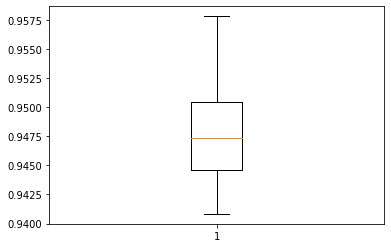

In [163]:
# Let's evaluate the model performance by using KFold and cross_val_score

scoring='recall'

kfold=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)     #Setting number of splits equal to 5
cv_result_bfr=cross_val_score(estimator=bagging_gridsearch, X=X_train, y=y_train, scoring=scoring, cv=kfold)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on the training data varies between 0.94 to 0.9575.

Accuracy on training set :  0.9706681074317888
Accuracy on test set :  0.9657300202368709
Recall on training set :  0.9583705666656396
Recall on test set :  0.951614062837012
Precision on training set :  0.9776199157603571
Precision on test set :  0.9735216240070609
f1 on training set :  0.9678995440895016
f1 on test set :  0.9624431921468823


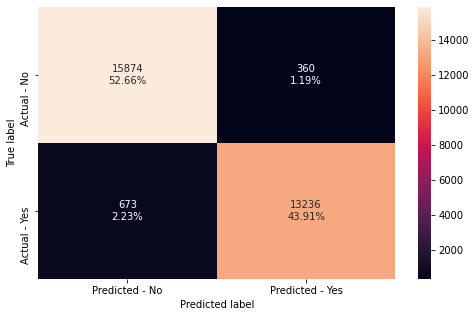

In [48]:
# Calculating different metrics
bagging_gridsearch_score=get_metrics_score(bagging_gridsearch)

# Creating confusion matrix
make_confusion_matrix(bagging_gridsearch, y_test)

- Model produced good score.

### AdaBoost GridSearch

In [165]:
import time
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(MinMaxScaler(), AdaBoostClassifier(random_state=42))

param_grid = {"adaboostclassifier__n_estimators":[100, 200, 300], 
              "adaboostclassifier__learning_rate":[0.001, 0.01, 0.1],
              "adaboostclassifier__base_estimator": [
        DecisionTreeClassifier(max_depth=8, random_state=42),
        DecisionTreeClassifier(max_depth=10, random_state=42),
        DecisionTreeClassifier(max_depth=12, random_state=42)]
} 

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base, end_base)

print("AdaBoost GridSearch execution time is {a}".format(a=execution_time))
print("Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_))

AdaBoost GridSearch execution time is 0:26:36
Best Parameters:{'adaboostclassifier__base_estimator': DecisionTreeClassifier(max_depth=8, random_state=42), 'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 100} 
Score: 0.9600961429831383


In [49]:
# Creating new pipeline with best parameters

adaboost_gridsearch = make_pipeline(
    MinMaxScaler(),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8, random_state=42),
                       learning_rate=0.1, n_estimators=100))

# Fit the model on training data
adaboost_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8,
                                                                          random_state=42),
                                    learning_rate=0.1, n_estimators=100))])

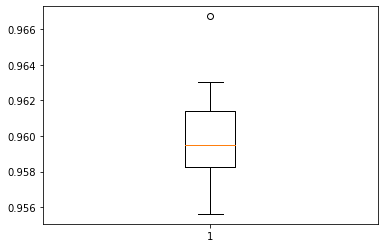

In [168]:
# Let's evaluate the model performance by using KFold and cross_val_score

scoring='recall'

kfold=StratifiedKFold(n_splits=10, shuffle=True,random_state=42)     #Setting number of splits equal to 5
cv_result_bfr=cross_val_score(estimator=adaboost_gridsearch, X=X_train, y=y_train, scoring=scoring, cv=kfold)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance onthe training data varies between 0.956 to 0.966.

Accuracy on training set :  0.9886824108171128
Accuracy on test set :  0.9654646186510965
Recall on training set :  0.9913105105845377
Recall on test set :  0.9603134661010856
Precision on training set :  0.9842741318647698
Precision on test set :  0.9646829409215658
f1 on training set :  0.9877797905984218
f1 on test set :  0.9624932444604576


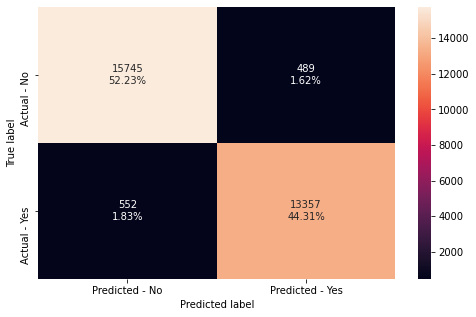

In [50]:
# Calculating different metrics
adb_gridsearch_score = get_metrics_score(adaboost_gridsearch)

# Creating confusion matrix
make_confusion_matrix(adaboost_gridsearch, y_test)

- Model produced good score.

### GradientBoost GridSearch

In [170]:
import time
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(MinMaxScaler(), GradientBoostingClassifier(random_state=42))

param_grid = {"gradientboostingclassifier__max_depth":[8, 10 ,12], 
              #"gradientboostingclassifier__max_features": [0.7, 0.8, 0.9],
              #"gradientboostingclassifier__min_samples_split": [3, 5, 7], 
              #"gradientboostingclassifier__min_samples_leaf": [2, 3, 5], 
              "gradientboostingclassifier__learning_rate":[0.001, 0.01, 0.1], 
              "gradientboostingclassifier__n_estimators":[200, 300, 400]} 

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base, end_base)

print("GradientBoost GridSearch execution time is {a}".format(a=execution_time))
print("Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_))

GradientBoost GridSearch execution time is 0:45:11
Best Parameters:{'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 8, 'gradientboostingclassifier__n_estimators': 200} 
Score: 0.9601268836743004


In [51]:
# Creating new pipeline with best parameters

gradientboost_gridsearch = make_pipeline(
    MinMaxScaler(),
    GradientBoostingClassifier(random_state=42, max_depth=8, learning_rate=0.1, n_estimators=200))

# Fit the model on training data
gradientboost_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=8, n_estimators=200,
                                            random_state=42))])

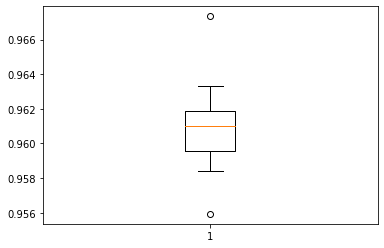

In [172]:
# Let's evaluate the model performance by using KFold and cross_val_score

scoring='recall'

kfold=StratifiedKFold(n_splits=10, shuffle=True,random_state=42)     #Setting number of splits equal to 5
cv_result_bfr=cross_val_score(estimator=gradientboost_gridsearch, X=X_train, y=y_train, scoring=scoring, cv=kfold)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on the training data varies between 0.956 to 0.966. 

Accuracy on training set :  0.9827392546884108
Accuracy on test set :  0.9670570281657432
Recall on training set :  0.9821896280775275
Recall on test set :  0.9603134661010856
Precision on training set :  0.9804373904217034
Precision on test set :  0.9680388462095956
f1 on training set :  0.981312727048827
f1 on test set :  0.9641606814162486


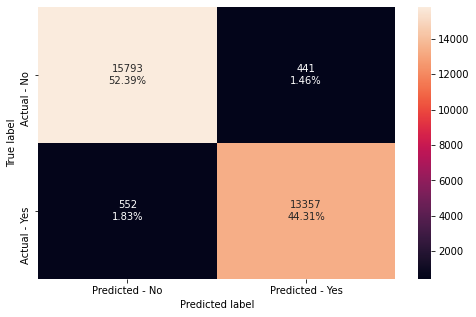

In [52]:
# Calculating different metrics
gdb_gridsearch_score = get_metrics_score(gradientboost_gridsearch)

# Creating confusion matrix
make_confusion_matrix(gradientboost_gridsearch, y_test)

- Model produced good score.

### XGBoost GridSearch

In [175]:
import time
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(MinMaxScaler(), XGBClassifier(random_state=42, eval_metric="logloss"))

param_grid = {
    "xgbclassifier__max_depth": [8, 10, 14], 
    "xgbclassifier__n_estimators": np.arange(200, 400, 100),
    "xgbclassifier__min_child_weight": [1, 3, 5],
    "xgbclassifier__learning_rate": [0.001, 0.01, 0.1, 1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base, end_base)

print("XGBoost GridSearch execution time is {a}".format(a=execution_time))
print("Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_))

XGBoost GridSearch execution time is 0:40:19
Best Parameters:{'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 14, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__n_estimators': 300} 
Score: 0.9588943414533189


In [53]:
# Creating new pipeline with best parameters

xgboost_gridsearch = make_pipeline(
    MinMaxScaler(),
    XGBClassifier(random_state=42, eval_metric="logloss", learning_rate= 0.1, max_depth= 14, min_child_weight=3,
                  n_estimators=300))

# Fit the model on training data
xgboost_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=3, missing=nan,
                               monotone_constraints='()', n_estimators=300,
                               n_jobs=8, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

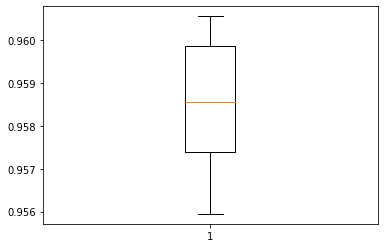

In [177]:
# Let's evaluate the model performance by using KFold and cross_val_score

scoring='recall'

kfold=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)     #Setting number of splits equal to 5
cv_result_bfr=cross_val_score(estimator=xgboost_gridsearch, X=X_train, y=y_train, scoring=scoring, cv=kfold)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on the training data varies between 0.956 to 0.960.

Accuracy on training set :  0.9852842904468742
Accuracy on test set :  0.9683840360946157
Recall on training set :  0.9810495177641513
Recall on test set :  0.9581565892587534
Precision on training set :  0.986979973959948
Precision on test set :  0.9729157541246898
f1 on training set :  0.9840058104495372
f1 on test set :  0.9654797696236462


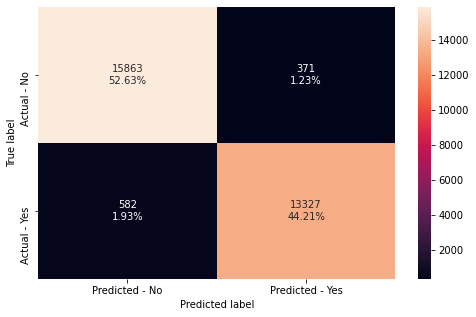

In [54]:
# Calculating different metrics
xgb_gridsearch_score = get_metrics_score(xgboost_gridsearch)

# Creating confusion matrix
make_confusion_matrix(xgboost_gridsearch, y_test)

- Model produced good score.

--------

## Compare Models performance.

In [58]:
# defining list of models
models = [gnb_gridsearch, dtree_gridsearch, rf_gridsearch, lightgbm_gridsearch, extra_tree_gridsearch, 
          catboost_gridsearch, knn_gridsearch, bagging_gridsearch, adaboost_gridsearch, gradientboost_gridsearch, 
         xgboost_gridsearch]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []

# looping through all the models to get the metrics score - Accuracy, Recall and Precision
for model in models:

    j = get_metrics_score(model, False) # False is used to supress the output of all the model scores.
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])

In [62]:
comparison_frame = pd.DataFrame(
    {
        "Model": [
            'GaussianNB GridSearch', 'DecisionTree GridSearch', 'RandomForest GridSearch', 'LightGBM GridSearch',
            'ExtraTree GridSearch', 'CatBoost GridSearch', 'KNN GridSearch', 'Bagging GridSearch', 'AdaBoost GridSearch',
            'GradientBoost GridSearch','XGBoost GridSearch'],
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Recall": recall_train,
        "Test_Recall": recall_test,
        "Train_Precision": precision_train,
        "Test_Precision": precision_test,
        "Train_F1": f1_train,
        "Test_F1": f1_test
    }
)

In [73]:
# sort the data by highest recall and precision score
comparison_frame.sort_values(['Test_Recall','Test_Precision','Test_F1']
                             ,ascending=[False, False, False], inplace=True)

# reset the index column.
comparison_frame = comparison_frame.reset_index(drop=True)
comparison_frame.style.background_gradient(subset=(['Test_Recall','Test_Precision','Test_F1']),cmap='Blues')

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1,Test_F1
0,GradientBoost GridSearch,0.982739,0.967057,0.982190,0.960313,0.980437,0.968039,0.981313,0.964161
1,AdaBoost GridSearch,0.988682,0.965465,0.991311,0.960313,0.984274,0.964683,0.987780,0.962493
2,XGBoost GridSearch,0.985284,0.968384,0.981050,0.958157,0.986980,0.972916,0.984006,0.965480
3,RandomForest GridSearch,0.970725,0.965830,0.965519,0.957581,0.970874,0.968021,0.968189,0.962773
4,LightGBM GridSearch,0.979128,0.966758,0.974517,0.956575,0.980135,0.970955,0.977318,0.963711
5,Bagging GridSearch,0.970668,0.965730,0.958371,0.951614,0.977620,0.973522,0.967900,0.962443
6,DecisionTree GridSearch,0.961242,0.959991,0.954457,0.951398,0.961270,0.961491,0.957851,0.956418
7,CatBoost GridSearch,0.961014,0.959327,0.938865,0.935222,0.975726,0.975624,0.956941,0.954996
8,KNN GridSearch,0.997384,0.912053,0.996949,0.894816,0.997380,0.912865,0.997165,0.903750
9,GaussianNB GridSearch,0.933047,0.932024,0.854898,0.852685,1.000000,1.000000,0.921774,0.920486


- From the above, we can observe that both GradientBoost Gridsearch and AdaBoost Gridsearch models produced the same highest recall score. However, precision, accuracy, and f1 are is slightly better for GradientBoost GridSearch.Therefore, we select GradientBoost as the best model for production. 

-----------

## Model Evaluation(ROC-AUC Curve).
- AUC ROC (Area Under the Curve, Receiver Characteristic Operator): AUC-ROC curve helps us visualize how well our machine learning classifier is performing. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. So, the higher the AUC value for a classifier, the better its ability to distinguish between positive and negative classes. We plot the AUC ROC curve on the best two or three models to evaluate which model can distinguish better in identifying positive and negative classes.

In [74]:
# predict probabilities on the best 3 models.

gbc_grid_pred_prob = gradientboost_gridsearch.predict_proba(X_test)
adb_pred_prob = adaboost_gridsearch.predict_proba(X_test)
xgb_grid_pred_prob = xgboost_gridsearch.predict_proba(X_test)

In [75]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, gbc_grid_pred_prob[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, adb_pred_prob[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, xgb_grid_pred_prob[:,1], pos_label=1)

In [76]:
# roc curve for tpr = fpr 

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [77]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score_gbc_grid_search = roc_auc_score(y_test, gbc_grid_pred_prob[:,1])
auc_score_adb_random_search = roc_auc_score(y_test, adb_pred_prob[:,1])
auc_score_xgb_grid_search = roc_auc_score(y_test, xgb_grid_pred_prob[:,1])

In [81]:
# print AUC ROC score for top models.

print('GradientBoost GridSearch AUC ROC score is {a:.3f}'.format(a=auc_score_gbc_grid_search))
print('AdaBoost GridSearch AUC ROC score is {b:.3f}'.format(b=auc_score_adb_random_search))
print('XGBoost GridSearch AUC ROC score is {b:.3f}'.format(b=auc_score_xgb_grid_search))

GradientBoost GridSearch AUC ROC score is 0.994
AdaBoost GridSearch AUC ROC score is 0.991
XGBoost GridSearch AUC ROC score is 0.995


- From the above, we can observe that the XGBoost model able to distinguish better between Postive and Negative classes by 0.001 percent comparing to GradientBoost GridSearch model.

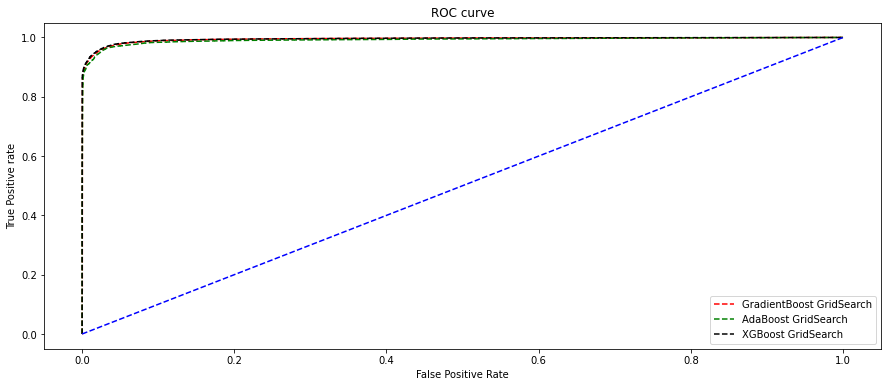

In [79]:
# Plot the AUC ROC curve for the models.

plt.figure(figsize=(15,6))
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='GradientBoost GridSearch')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='AdaBoost GridSearch')
plt.plot(fpr3, tpr3, linestyle='--',color='black', label='XGBoost GridSearch')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

- **From the model performance scores and AUC ROC curve further we can confirm that GradientBoost GridSearch is the best model to put in production to predict Bad debt customers.**

---------------

## Model Evaluation(Confusion Matrix)
- A Confusion matrix is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model. This gives us a holistic view of how well our classification model is performing and what kinds of errors it is making.

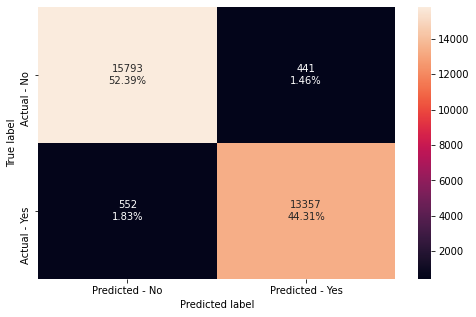

In [82]:
# Best model confusion matrix
make_confusion_matrix(gradientboost_gridsearch, y_test)

**Interpretation of above confusion matrix (GradientBoost GridSearch):**

- 15793 (True Positive) of the customers we predicted they will not become bad debt, and did not become bad debt.
- 441 (False Positive) of the customers we predicted will become bad debt, and they did not become bad debt.
- 13357 (True Negative) of the customers we predicted they will become bad debt, and they become bad debt.
- 552 (False Negative) of the customers we predicted they will not become bad debt and they did become bad debt.

-------------

## Business Insight and Recommendations

    1) Most Government agencies have bad debts. We have to gather more info as to why Govt agencies have bad debts. We need to get more information on Unknown properties as we can see we have a significantly higher proportion of bad debts in the Unknown category.
    2) Few properties have Value and Property size zero; we need more information on why we have 0 value for this.
    3) Significantly higher proportion of Bill amount or debt amount to be collected, we have to come with a strategy of smart payment option, so that residents should not feel the crunch of paying a hefty amount.
    4) When the Customer has an ID, we can observe a higher proportion of default. We need to get more insight into how the HasID feature affects the bad debt status.
    5) We need to be more careful with customers whose property value and size are more significant; few customers have bad debts when their property size or value is significantly larger.
    6) We have to take some precautionary measures when observing that the Average bill amount goes negative after a certain threshold.
    7) Introduce a new payment system or methods to pay the society management. If we have yearly payment, introduce month, quarterly also setting up Direct debit. Encourage Direct debits to pay the society fees. 
    8) Offer incentives for early payers. Within your payment terms, there could also be scope to offer incentives for timely payment, such as a small discount. Structuring your payment terms to encourage prompt payment is a more favorable approach over issuing late fees and penalties for outstanding invoices – as these are likely to get your clients offside and make them recalcitrant to pay.
    9) Stay in touch. Our relationship with your client is just like any other in your life – you need to work on it. We need to check in with them regularly, or even pick up the phone for that matter.
    10) Prevention is better than collection. It’s crucial that out accounting systems and processes give us an accurate representation of who owes what at a glance. There are plenty of software providers that offer this for us – the key, though, is to ensure that customer’s details and invoices are always kept up to date. This will empower us to identify trends of clients who are regularly carrying outstanding invoices, and who owes us money.
    11) Send out your invoices promptly. It’s important to make sure we send out invoices on time – the sooner we send them, the sooner they are due. Late invoices can be missed. It’s also good to be aware of our clients’ payment cycles – some businesses only pay monthly, so it’s crucial to send invoice to catch the right payment schedule. Once payment is overdue, ensure we have the systems and processes in place that will ensure we can recover it effectively. This might be as simple as picking up the phone or it might be working with a debt collection company. The latter option leaves us free to work on our business and saves us the headache of chasing invoices.

# The End

-------